Custom code for DE analyses between species and sexes in: <br>
"Evolution of gene expression across brain regions in behaviorally divergent deer mice" <br><br>
Written by Andi Kautt in 2018/2019 <br><br>
I highly recommend installing https://jupyter-contrib-nbextensions.readthedocs.io/en/latest/ and turning the TOC option on <br><br>
NOTE: "mPFC" = "cortex" in paper

## Set up environment

In [1]:
library(DESeq2)
library(edgeR)
library(cowplot)
library(mashr)
library(profmem)
library(VennDiagram)
library(WebGestaltR)
library(corrplot)
library(pheatmap)
library(dendsort)
library(RColorBrewer)
library(tidyverse)

Loading required package: S4Vectors
Loading required package: stats4
Loading required package: BiocGenerics
Loading required package: parallel

Attaching package: ‘BiocGenerics’

The following objects are masked from ‘package:parallel’:

    clusterApply, clusterApplyLB, clusterCall, clusterEvalQ,
    clusterExport, clusterMap, parApply, parCapply, parLapply,
    parLapplyLB, parRapply, parSapply, parSapplyLB

The following objects are masked from ‘package:stats’:

    IQR, mad, sd, var, xtabs

The following objects are masked from ‘package:base’:

    anyDuplicated, append, as.data.frame, basename, cbind, colMeans,
    colnames, colSums, dirname, do.call, duplicated, eval, evalq,
    Filter, Find, get, grep, grepl, intersect, is.unsorted, lapply,
    lengths, Map, mapply, match, mget, order, paste, pmax, pmax.int,
    pmin, pmin.int, Position, rank, rbind, Reduce, rowMeans, rownames,
    rowSums, sapply, setdiff, sort, table, tapply, union, unique,
    unsplit, which, which.max, which

In [2]:
sessionInfo()

R version 3.5.1 (2018-07-02)
Platform: x86_64-conda_cos6-linux-gnu (64-bit)
Running under: Rocky Linux 8.7 (Green Obsidian)

Matrix products: default
BLAS/LAPACK: /n/home00/akautt/.conda/envs/work/lib/R/lib/libRlapack.so

locale:
 [1] LC_CTYPE=en_US.UTF-8       LC_NUMERIC=C              
 [3] LC_TIME=en_US.UTF-8        LC_COLLATE=en_US.UTF-8    
 [5] LC_MONETARY=en_US.UTF-8    LC_MESSAGES=en_US.UTF-8   
 [7] LC_PAPER=en_US.UTF-8       LC_NAME=C                 
 [9] LC_ADDRESS=C               LC_TELEPHONE=C            
[11] LC_MEASUREMENT=en_US.UTF-8 LC_IDENTIFICATION=C       

attached base packages:
 [1] grid      parallel  stats4    stats     graphics  grDevices utils    
 [8] datasets  methods   base     

other attached packages:
 [1] forcats_0.4.0               stringr_1.4.0              
 [3] dplyr_0.8.1                 purrr_0.3.2                
 [5] readr_1.3.1                 tidyr_0.8.3                
 [7] tibble_2.1.3                ggplot2_3.1.1              
 [9] tidyve

In [3]:
stem_path="/n/hoekstra_lab_tier1/Users/akautt/projects/Peromyscus_RNAseq_brain"

setwd(file.path(stem_path,"data/RSEM_count_tables"))

plot_path=file.path(stem_path,"results_plots_tables/")

In [4]:
# Overwrite default draw_colnames in pheatmap package
# code found here http://stackoverflow.com/questions/15505607
draw_colnames_45 <- function (coln, gaps, ...) {
    coord <- pheatmap:::find_coordinates(length(coln), gaps)
    x     <- coord$coord - 0.5 * coord$size
    res   <- grid::textGrob(
      coln, x = x, y = unit(1, "npc") - unit(3,"bigpts"),
      vjust = 0.75, hjust = 1, rot = 45, gp = grid::gpar(...)
    )
    return(res)
}
assignInNamespace(
  x = "draw_colnames",
  value = "draw_colnames_45",
  ns = asNamespace("pheatmap")
)

## Load data

### Count tables and input.meta files

In [5]:
input <- read.table("BW_PO_F1sum.all_subregions_WB.genes.shared.count.matrix", header=T, row.names=1, sep="\t")

input.meta <- read.table("BW_PO_F1sum.all_subregions_WB.genes.shared.info.txt", header=T, sep="\t", colClasses="factor")

In [6]:
# remove all F1 samples - we're only interested in parental species here

input <- input %>% select(-matches("F1"))
input.meta <- input.meta %>% filter(species!="F1")

# define subregions w/ and w/o whole brain samples (only males)

subregions_WB <- input.meta$tissue %>% unique()
subregions <- subregions_WB[1:10]

### Load gene lists

In [7]:
# lists of pseudogenes - identified by blast to NCBI Pman_1.0 annotation and from Mus ENSEMBL 

pseudogenes.Pman <- read.table(file.path(stem_path,"lists/Pman_2.1.3.JC_blast_from_old_NCBI.pseudogenes.genelist.tsv"),
                        header=F, colClasses=c("character"))
colnames(pseudogenes.Pman) <- c("gene"); nrow(pseudogenes.Pman)

pseudogenes.Mmus <- read.table(file.path(stem_path,"lists/mmusculus_gene_ensembl_GRRCm38.p6.pseudogenes.genelist.tsv"),
                        header=T, colClasses=c("character"))
colnames(pseudogenes.Mmus) <- c("gene"); nrow(pseudogenes.Mmus)

pseudogenes <- rbind(pseudogenes.Pman,pseudogenes.Mmus) %>% unique(); nrow(pseudogenes)

[1] 825

[1] 13744

[1] 14235

In [8]:
# load list of chrX genes

chrX_genes <- read.table(file.path(stem_path,"lists/Pman_2.1.3_Ppol_1.3.3.gene_name.chrX.genelist.txt"), 
                        header=F, fill=T)
colnames(chrX_genes) <- c("gene")

In [9]:
# genes related to monogamous mating systems (from Young et al. correction SI list)

Young_monogamy_genes <- read.table(file.path(stem_path,"lists/Young_et_al_2019_monogamy.corrected.genelist.txt"), 
                        header=F, fill=T); colnames(Young_monogamy_genes) <- c("gene")

## Sex-bias in both species

### DESeq2 to estimate log fold change (effect size) + SE

In [10]:
# BW = P. maniculatus bairdii stock
# PO = P. polionotus subgriseus stock

for (subregion in subregions){

    input_sub.BW <- input %>% select(matches("BW_")) %>% select(matches(paste0("_",subregion)))
    input.meta_sub.BW <- input.meta %>% filter(species=="BW" & tissue == subregion) %>% droplevels()
    
    rnaseqMatrix_sub.BW <- input_sub.BW %>% na.omit() %>% round()
    keep.BW = rowSums(cpm(rnaseqMatrix_sub.BW)>=1)>=3
    rnaseqMatrix_sub.BW <- rnaseqMatrix_sub.BW[keep.BW,]
    
    assign(paste0("dds_",subregion,".BW"), DESeqDataSetFromMatrix(countData=rnaseqMatrix_sub.BW, 
                                                    colData=input.meta_sub.BW, design = ~sex))
    assign(paste0("dds_",subregion,".BW"), DESeq(get(paste0("dds_",subregion,".BW")), minReplicatesForReplace=5))
    

    input_sub.PO <- input %>% select(matches("PO_")) %>% select(matches(paste0("_",subregion)))
    input.meta_sub.PO <- input.meta %>% filter(species=="PO" & tissue == subregion) %>% droplevels()
    
    rnaseqMatrix_sub.PO <- input_sub.PO %>% na.omit() %>% round()
    keep.PO = rowSums(cpm(rnaseqMatrix_sub.PO)>=1)>=3
    rnaseqMatrix_sub.PO <- rnaseqMatrix_sub.PO[keep.PO,]
    
    assign(paste0("dds_",subregion,".PO"), DESeqDataSetFromMatrix(countData=rnaseqMatrix_sub.PO, 
                                                    colData=input.meta_sub.PO, design = ~sex))
    assign(paste0("dds_",subregion,".PO"), DESeq(get(paste0("dds_",subregion,".PO")), minReplicatesForReplace=5))

}

converting counts to integer mode
estimating size factors
estimating dispersions
gene-wise dispersion estimates
mean-dispersion relationship
final dispersion estimates
fitting model and testing
converting counts to integer mode
estimating size factors
estimating dispersions
gene-wise dispersion estimates
mean-dispersion relationship
final dispersion estimates
fitting model and testing
converting counts to integer mode
estimating size factors
estimating dispersions
gene-wise dispersion estimates
mean-dispersion relationship
final dispersion estimates
fitting model and testing
converting counts to integer mode
estimating size factors
estimating dispersions
gene-wise dispersion estimates
mean-dispersion relationship
final dispersion estimates
fitting model and testing
converting counts to integer mode
estimating size factors
estimating dispersions
gene-wise dispersion estimates
mean-dispersion relationship
final dispersion estimates
fitting model and testing
converting counts to integer m

In [11]:
for (subregion in subregions){
    
# use DESeq's results function to pull out DE genes
    assign(paste0("res.sex_",subregion,".BW"), results(get(paste0("dds_",subregion,".BW")), alpha=0.05, 
                                             name="sex_M_vs_F", pAdjustMethod="fdr"))
    assign(paste0("res.sex_",subregion,".PO"), results(get(paste0("dds_",subregion,".PO")), alpha=0.05, 
                                             name="sex_M_vs_F", pAdjustMethod="fdr"))

# add subregion and species info
    assign(paste0("prep.sex_",subregion,".BW"), get(paste0("res.sex_",subregion,".BW")) %>% as.data.frame() %>% 
                       mutate("gene"=rownames(.)) %>% mutate("subregion"=subregion,"species"="BW"))
    assign(paste0("prep.sex_",subregion,".PO"), get(paste0("res.sex_",subregion,".PO")) %>% as.data.frame() %>% 
                       mutate("gene"=rownames(.)) %>% mutate("subregion"=subregion, "species"="PO"))
}

In [12]:
# combine subregion sex results

data.list.BW = list()
data.list.PO = list()

for (subregion in subregions){
    data.list.BW[[subregion]] <- get(paste0("prep.sex_",subregion,".BW"))
    data.list.PO[[subregion]] <- get(paste0("prep.sex_",subregion,".PO"))}

all.sex <- do.call(rbind, c(data.list.BW,data.list.PO))

In [13]:
# create two matrices, one with effect and one with SE for mashr
# NOTE: set missing LFCs to 0 and missing lfcSEs to 1000 - missing data not allowed in mashr

all.sex.LFC <- all.sex %>% unite("condition", species, subregion) %>% select(gene,condition,log2FoldChange) %>% 
    spread(condition,log2FoldChange) %>% column_to_rownames("gene") %>% replace(., is.na(.), 0) %>% as.matrix()

all.sex.SE <- all.sex %>% unite("condition", species, subregion) %>% select(gene,condition,lfcSE) %>% 
    spread(condition,lfcSE) %>% column_to_rownames("gene") %>% replace(., is.na(.), 1000) %>% as.matrix()

# create same-sized matrix with "1"s and NAs to fill NAs back into final data frame via matrix multiplication

all.sex.NAs <- all.sex %>% unite("condition", species, subregion) %>% select(gene,condition,lfcSE) %>% 
    spread(condition,lfcSE) %>% mutate_if(is.numeric, ~if_else(!is.na(.), 1, .)) %>% 
    column_to_rownames("gene") %>% as.matrix()

### mashr

mostly following mashr vignettes (copy/pasted some of their comments as annotation below): <br>
https://stephenslab.github.io/mashr/articles/intro_mash.html <br> https://stephenslab.github.io/mashr/articles/intro_mash_dd.html

#### Sparse factor analysis (SFA)

In [14]:
# create matrix of Z-scores (effect divided by SE) for SFA

all.sex.lfcZ <- all.sex %>% unite("condition", species, subregion) %>% mutate("lfcZ"=log2FoldChange/lfcSE) %>% 
    select(gene,condition,lfcZ) %>% spread(condition,lfcZ) %>% column_to_rownames("gene") %>% 
    replace(., is.na(.), 0) %>% as.data.frame()

# write to file
file_name=paste0(plot_path,"out_RSEM.BW_PO.all_subregions.sex.lfcZ.forSFA.tsv")
#if(!file.exists(file_name)) {
    write_tsv(all.sex.lfcZ, file_name, col_names=F)
#}

cat("SFA n =",ncol(all.sex.lfcZ),"\nSFA g =",nrow(all.sex.lfcZ))

SFA n = 20 
SFA g = 15975

In [15]:
# system call to run sparse factor analysis (SFA) externally
# adjust n and g and choose k = number of clusters

no_SFs=5

if(!file.exists(file.path(plot_path,"out_SFA.all_subregion.sex.lfcZ.k5_F.out"))) {

    system(sprintf("module load gsl; ~/software/sfa_1.0/bin/sfa_linux \\
    -gen /n/hoekstra_lab_tier1/Users/akautt/projects/Peromyscus_RNAseq_brain/results_plots_tables/out_RSEM.BW_PO.all_subregions.sex.lfcZ.forSFA.tsv \\
    -t -n 20 -g 15975 -k %s -iter 20 -rand 5 \\
    -o /n/hoekstra_lab_tier1/Users/akautt/projects/Peromyscus_RNAseq_brain/results_plots_tables/out_SFA.all_subregion.sex.lfcZ.k5", no_SFs),
    intern=F)
}

sf.sex = as.matrix(read.delim(file.path(plot_path,"out_SFA.all_subregion.sex.lfcZ.k5_F.out"),header=F))
sf.sex

V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20
-0.0776115,-0.4482330,-1.012390,0.836354,-0.4592130,0.576976,-0.528176,0.6290240,0.8380380,1.5299300,-0.536445,-0.0097431,-0.075201,-0.626192,-0.260909,2.491870,1.938010,-0.0058156,-1.1127900,-1.449270
-0.5287260,-0.0173166,-1.671720,-0.263829,-0.5110560,0.815553,0.260377,0.0830261,-0.2707310,0.0123489,0.401749,-0.0128383,1.595190,-0.996112,-0.639687,0.607930,-2.319890,0.5197890,-0.0287926,2.380830
0.0968934,0.2650010,0.355361,-0.510783,0.4458030,-0.995614,-0.701838,1.2329200,-1.5326200,1.4172500,0.639838,-0.2749240,1.186170,2.154470,-0.172559,-2.002310,0.697372,0.2960260,0.4460450,1.243300
-1.6725800,0.2138580,-0.852429,0.447850,-1.0328600,-2.004430,0.573628,1.8923700,0.9968000,0.2576280,0.011346,-0.3813080,-1.703810,0.942810,-0.403497,-0.772463,-1.187960,0.8380380,-0.1598630,-0.645244
2.3810800,-0.0329395,-2.408810,0.595553,-0.0327373,-0.603621,0.961531,-0.3960700,0.0507934,0.0329237,0.190183,0.8422830,0.425925,-0.303881,0.499197,-0.401900,-1.420470,-0.5346390,-0.1597480,-1.784100


#### Create covariance matrices

In [16]:
# create mashr data object
mashr.sex.data = mash_set_data(all.sex.LFC, all.sex.SE)

# add correlations - https://stephenslab.github.io/mashr/articles/intro_correlations.html
V.sex = estimate_null_correlation_simple(mashr.sex.data)
mashr.sex.data.V = mash_update_data(mashr.sex.data, V=V.sex)

# generate canoncial covariance matrices
U.can.sex = cov_canonical(mashr.sex.data)

# run ashr across all conditions and extract strong effects - use as initial conditions for ED
m.1by1.sex = mash_1by1(mashr.sex.data)
strong.sex = get_significant_results(m.1by1.sex, 0.05)

# generate PCA-based covariance matrices
no_PCs=5
U.pca.sex = cov_pca(mashr.sex.data, no_PCs, subset=strong.sex)

# generate SFA-based covariance matrices
U.sfa.sex = cov_from_factors(sf.sex, name = c(sprintf("SFA_%02d", seq(1,no_SFs))))

# generate extreme deconvolution-based covariance matrices based on PCA and SFA
U.ed.sex = cov_ed(mashr.sex.data, c(U.pca.sex,U.sfa.sex), subset=strong.sex)

#### Run mashr

In [17]:
# only canonical
m.can.sex = mash(mashr.sex.data.V, c(U.can.sex), algorithm.version="Rcpp", 
                 verbose=T, add.mem.profile=T, outputlevel=2)

 - Computing 15975 x 676 likelihood matrix.
 - Likelihood calculations allocated 880.53 MB and took 46.73 seconds.
 - Fitting model with 676 mixture components.
 - Model fitting allocated 917.95 MB and took 25.71 s.
 - Computing posterior matrices.
 - Computation allocated 169.30 MB and took 401.57 s.


In [18]:
# only extreme deconvolution - only works with normalizeU=F
m.ed.sex = mash(mashr.sex.data.V, c(U.ed.sex), algorithm.version="Rcpp", 
                 normalizeU=F, verbose=T, add.mem.profile=T, outputlevel=2)

 - Computing 15975 x 298 likelihood matrix.
 - Likelihood calculations allocated 394.34 MB and took 21.56 seconds.
 - Fitting model with 298 mixture components.
 - Model fitting allocated 405.42 MB and took 8.91 s.
 - Computing posterior matrices.
 - Computation allocated 167.55 MB and took 274.36 s.


In [19]:
# canoncial and extreme deconvolution - only works with normalizeU=F
m.can.ed.sex = mash(mashr.sex.data.V, c(U.can.sex,U.ed.sex), algorithm.version="Rcpp", 
                 normalizeU=F, verbose=T, add.mem.profile=T, outputlevel=2)

 - Computing 15975 x 973 likelihood matrix.
 - Likelihood calculations allocated 1262.47 MB and took 62.70 seconds.
 - Fitting model with 973 mixture components.
 - Model fitting allocated 1323.72 MB and took 46.93 s.
 - Computing posterior matrices.
 - Computation allocated 170.63 MB and took 473.05 s.


In [20]:
# compare log-likelihoods
cat("m.can.sex:",get_loglik(m.can.sex),"\n")
cat("m.ed.sex:",get_loglik(m.ed.sex),"\n")
cat("m.can.ed.sex:",get_loglik(m.can.ed.sex))

m.can.sex: -154557.7 
m.ed.sex: -154431 
m.can.ed.sex: -153277.4

### Analyses

In [21]:
# fill in NAs as 0 for effect size and SD and 1 for lfsr for genes that were too lowly expressed
# mashr will sometimes adjust effect size from zero to something, which is not sensible for genes that are not expressed in a certain region

# check if gene names and order are identical
all.equal(rownames(m.can.ed.sex$result$PosteriorMean), rownames(all.sex.NAs))

m.can.ed.sex.NAs <- m.can.ed.sex
m.can.ed.sex.NAs$result$PosteriorMean <- (m.can.ed.sex$result$PosteriorMean * all.sex.NAs) %>% replace_na(0)
m.can.ed.sex.NAs$result$PosteriorSD <- (m.can.ed.sex$result$PosteriorSD * all.sex.NAs) %>% replace_na(0)
m.can.ed.sex.NAs$result$lfsr <- (m.can.ed.sex$result$lfsr * all.sex.NAs) %>% replace_na(1)


# write to file
file_name=paste0(plot_path,"/out_mashr.RSEM.BW_PO.all_subregions.sex.rda")
if(!file.exists(file_name)) {
    save(m.can.ed.sex.NAs, file=file_name)
}

[1] TRUE

In [ ]:
# load from file
attach(paste0(plot_path,"/out_mashr.RSEM.BW_PO.all_subregions.sex.rda"))

In [22]:
# parse mashr results into one data.frame

m.can.ed.sex.tall <- full_join(m.can.ed.sex.NAs$result$PosteriorMean %>% as.data.frame() %>% 
    rownames_to_column("gene") %>% gather("condition","LFC",-gene), 
                                m.can.ed.sex.NAs$result$PosteriorSD %>% as.data.frame() %>%  
    rownames_to_column("gene") %>% gather("condition","SD",-gene), by=c("gene","condition")) %>%
                        full_join(m.can.ed.sex.NAs$result$lfsr %>% as.data.frame() %>%  
    rownames_to_column("gene") %>% gather("condition","lfsr",-gene), by=c("gene","condition"))


# write to file
file_name=paste0(plot_path,"out_mashr.RSEM.BW_PO.all_subregions.sex.tsv")
if(!file.exists(file_name)) {
    write_tsv(m.can.ed.sex.tall, file_name)
}

#### Summary

In [23]:
conditions <- unique(m.can.ed.sex.tall$condition)
conditions

[1] "BW_amygdala"     "BW_cerebellum"   "BW_hindbrain"    "BW_hippocampus" 
 [5] "BW_hypothalamus" "BW_midbrain"     "BW_mPFC"         "BW_septum"      
 [9] "BW_striatum"     "BW_thalamus"     "PO_amygdala"     "PO_cerebellum"  
[13] "PO_hindbrain"    "PO_hippocampus"  "PO_hypothalamus" "PO_midbrain"    
[17] "PO_mPFC"         "PO_septum"       "PO_striatum"     "PO_thalamus"

In [24]:
# pull out vectors of significant genes...

m.can.ed.sex.sig <- list()

# in at least one condition
m.can.ed.sex.sig$all <- get_significant_results(m.can.ed.sex.NAs, thresh=0.05, sig_fn=get_lfsr, conditions=NULL)

# only in BWs
m.can.ed.sex.sig$BW <- get_significant_results(m.can.ed.sex.NAs, thresh=0.05, sig_fn=get_lfsr, 
                    conditions=c('BW_amygdala','BW_cerebellum','BW_hindbrain','BW_hippocampus',
                                 'BW_hypothalamus','BW_midbrain','BW_mPFC','BW_septum','BW_striatum','BW_thalamus'))

# only in POs
m.can.ed.sex.sig$PO <- get_significant_results(m.can.ed.sex.NAs, thresh=0.05, sig_fn=get_lfsr, 
                    conditions=c('PO_amygdala','PO_cerebellum','PO_hindbrain','PO_hippocampus',
                                 'PO_hypothalamus','PO_midbrain','PO_mPFC','PO_septum','PO_striatum','PO_thalamus'))

# in every single subregion
for (subregion in subregions){
    m.can.ed.sex.sig[[subregion]] <- get_significant_results(m.can.ed.sex.NAs, thresh=0.05, 
                        sig_fn=get_lfsr, conditions=c(paste0("BW_",subregion),paste0("PO_",subregion)))}


# in every single condition
for (condition in conditions){
    m.can.ed.sex.sig[[condition]] <- get_significant_results(m.can.ed.sex.NAs, thresh=0.05, 
                                                     sig_fn=get_lfsr, conditions=condition)}

In [25]:
# remove pseudogenes

m.can.ed.sex.sig.wo_pseudo <- lapply(m.can.ed.sex.sig, function(x){
    x[!names(x) %in% pseudogenes$gene %>% as.vector()]
})

In [26]:
# number of DE genes per condition and binomial test if F:M bias is significant in each conditions

summary.table.sex <- data.frame(matrix(nrow=length(conditions),ncol=7))
colnames(summary.table.sex) <- c("subregion","total.expressed","total.DE","female-biased","male-biased","ratio_F:M","binom.p")
i=1
for (condition in conditions){
    
    summary.table.sex[i,1] <- condition
    summary.table.sex[i,2] <- all.sex.NAs %>% as.data.frame() %>% select(condition) %>% na.omit() %>% 
            rownames_to_column("gene") %>% anti_join(pseudogenes, by="gene") %>% nrow()
    summary.table.sex[i,3] <- length(m.can.ed.sex.sig.wo_pseudo[[condition]])
    summary.table.sex[i,4] <- m.can.ed.sex.NAs$result$PosteriorMean[m.can.ed.sex.sig.wo_pseudo[[condition]],condition] %>% 
            as.data.frame() %>% summarise(upF=sum(.<0))
    summary.table.sex[i,5] <- m.can.ed.sex.NAs$result$PosteriorMean[m.can.ed.sex.sig.wo_pseudo[[condition]],condition] %>% 
            as.data.frame() %>% summarise(upM=sum(.>0))
    summary.table.sex[i,6] <- round(summary.table.sex[i,4]/summary.table.sex[i,5], 2)
    summary.table.sex[i,7] <- round(binom.test(summary.table.sex[i,4],summary.table.sex[i,3],
                                    p=0.5, alternative="two.sided", conf.level=0.95)$p.value, 4)
    i=i+1
}
summary.table.sex$binom.padj <- round(p.adjust(summary.table.sex$binom.p, method="holm"), 4)
summary.table.sex %>% separate(subregion,into=c("species","subregion"),sep="_") %>% 
    mutate(species=if_else(species=="BW","P. maniculatus","P. polionotus")) %>%
    mutate("significant"=if_else(binom.padj<0.05,"yes","no"))

cat("Total number of significant genes (across all regions): ", length(m.can.ed.sex.sig.wo_pseudo$all), "\n")
cat("Total number of expressed/analyzed genes (across all regions): ", 
    all.sex.NAs %>% as.data.frame() %>% rownames_to_column("gene") %>% anti_join(pseudogenes, by="gene") %>% nrow(), "\n")

species,subregion,total.expressed,total.DE,female-biased,male-biased,ratio_F:M,binom.p,binom.padj,significant
P. maniculatus,amygdala,13554,153,60,93,0.65,0.0095,0.1045,no
P. maniculatus,cerebellum,13226,124,44,80,0.55,0.0016,0.0224,yes
P. maniculatus,hindbrain,13704,130,49,81,0.60,0.0063,0.0756,no
P. maniculatus,hippocampus,13469,122,39,83,0.47,0.0001,0.0019,yes
P. maniculatus,hypothalamus,13922,155,56,99,0.57,0.0007,0.0112,yes
P. maniculatus,midbrain,13625,163,67,96,0.70,0.0280,0.2800,no
P. maniculatus,mPFC,13295,137,56,81,0.69,0.0399,0.3591,no
P. maniculatus,septum,13601,205,101,104,0.97,0.8890,1.0000,no
P. maniculatus,striatum,13438,151,85,66,1.29,0.1427,0.8562,no
P. maniculatus,thalamus,13425,173,98,75,1.31,0.0941,0.7528,no


Total number of significant genes (across all regions):  461 
Total number of expressed/analyzed genes (across all regions):  15503 


In [27]:
# significant differences between species across subregions?
test <- function(a,b){round(binom.test(a, b, p=0.5, alternative=c("two.sided"), conf.level=0.95)$p.value,4)}

summary.table.sex.subregions <- summary.table.sex %>% 
    separate(subregion,into=c("species","subregion"),sep="_") %>% 
    select(species,subregion,total.DE) %>% spread(species, total.DE) %>% 
    mutate(total=BW+PO) %>% 
    mutate("binom.p"=mapply(test, .$BW, .$total)) %>%
    rename("P. maniculatus"="BW","P. polionotus"="PO")

summary.table.sex.subregions$binom.padj <- round(p.adjust(summary.table.sex.subregions$binom.p, method="holm"), 4)

summary.table.sex.subregions %>% mutate("significant"=if_else(binom.padj<0.05,"yes","no"))

subregion,P. maniculatus,P. polionotus,total,binom.p,binom.padj,significant
amygdala,153,155,308,0.9546,0.9546,no
cerebellum,124,188,312,0.0003,0.0024,yes
hindbrain,130,165,295,0.0476,0.2856,no
hippocampus,122,192,314,0.0001,0.0009,yes
hypothalamus,155,185,340,0.1156,0.4624,no
midbrain,163,124,287,0.0247,0.1729,no
mPFC,137,119,256,0.2880,0.8640,no
septum,205,118,323,0.0000,0.0000,yes
striatum,151,133,284,0.3131,0.8640,no
thalamus,173,138,311,0.0537,0.2856,no


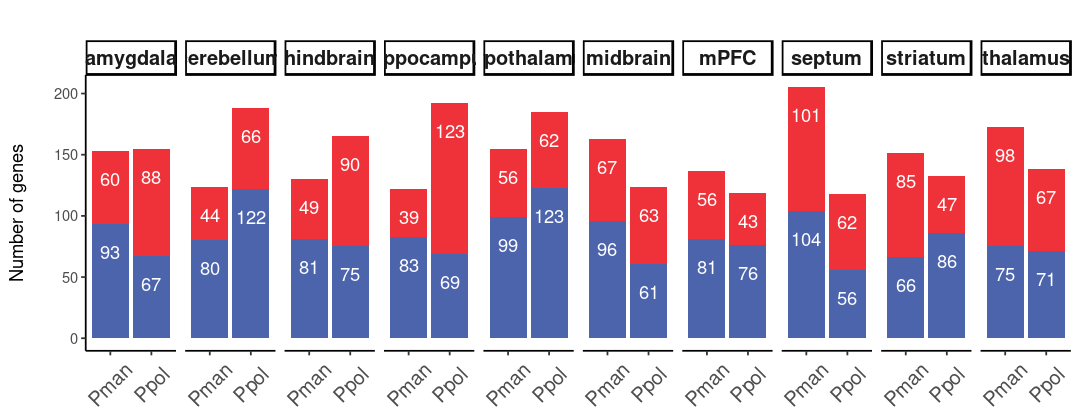

In [28]:
options(repr.plot.width=9, repr.plot.height=3.5)

m.can.ed.sex.tall %>% mutate(sr.DE.call=if_else(lfsr < 0.05 & LFC < 0, "female-biased", 
                                if_else(lfsr < 0.05 & LFC > 0, "male-biased", "not significant"))) %>%
    anti_join(pseudogenes, by="gene") %>%
    filter(sr.DE.call!="not significant") %>%
    group_by(condition,sr.DE.call) %>% tally() %>%
    mutate(total=sum(n), prop=n/total) %>%
    separate(condition,into=c("species","subregion") ,sep="_") %>% 
    mutate(species=if_else(species=="BW","Pman","Ppol")) %>% 
    ggplot( aes(x=species, y=n, fill=sr.DE.call)) + 
            geom_bar(stat="identity", position="stack", color=NA, alpha=0.9) + theme_classic() + 
            labs(y="Number of genes\n", x="Region", title="") + 
            scale_fill_manual(values=c("female-biased"="#ED1C24","male-biased"="#3953A3","not significant"="gray"), 
                              name="DE call") + 
            theme(plot.title=element_text(color="black", size=14, face="bold", hjust=0.5)) +
            theme(axis.text.x=element_text(angle=45,size=12,vjust=0.5)) + theme(axis.title.x=element_blank()) +
            geom_text(aes(label=n), position="stack", hjust=0.5, vjust=2.5, color="white") +
            facet_wrap(~subregion, nrow=1) + theme(strip.text=element_text(size=12,face="bold")) +
            theme(legend.position = "none")

file_name=paste0(plot_path,"out_RSEM.BW_PO.all_subregions.mashr.sex.DEcalls.abs.pdf")
if(!file.exists(file_name)) {
    ggsave(file_name, width=12, height=3.5)
}

#### Overlap between species

In [29]:
sig.sex.list=list()

sig.sex.list$all <- names(m.can.ed.sex.sig.wo_pseudo$all)
sig.sex.list$shared <- intersect(names(m.can.ed.sex.sig.wo_pseudo$BW), names(m.can.ed.sex.sig.wo_pseudo$PO))
sig.sex.list$BWspecific <- setdiff(names(m.can.ed.sex.sig.wo_pseudo$BW), names(m.can.ed.sex.sig.wo_pseudo$PO)) 
sig.sex.list$POspecific <- setdiff(names(m.can.ed.sex.sig.wo_pseudo$PO), names(m.can.ed.sex.sig.wo_pseudo$BW))
sig.sex.list$nonshared <- union(sig.sex.list$BWspecific,sig.sex.list$POspecific) 

lapply(sig.sex.list, length)

$all
[1] 461

$shared
[1] 203

$BWspecific
[1] 108

$POspecific
[1] 150

$nonshared
[1] 258

In [30]:
venn <- draw.pairwise.venn(length(names(m.can.ed.sex.sig.wo_pseudo$BW)), length(names(m.can.ed.sex.sig.wo_pseudo$PO)), 
                   length(sig.sex.list$shared), category=c("P. maniculatus","P. polionotus"), 
                    fill=c("P. maniculatus"="#FF9C00","P. polionotus"="#6495ED"),
                    cat.pos=c("P. maniculatus"=-12, "P. polionotus"=12), ind=F, 
                    cat.fontface=rep("italic",2), cat.fontfamily=rep("myriad",2), fontfamily=rep("myriad",3))

In [31]:
LFC <- m.can.ed.sex.tall %>% filter(lfsr < 0.05) %>% separate(condition,into=c("species","tissue")) %>% 
    ggplot( aes(x=LFC, fill=species)) + geom_density(alpha=0.4) + xlim(-2.5,2.5) +
        theme_classic() + geom_vline(aes(xintercept=0), linetype="dashed", color="darkgray", size=0.5) +
        scale_fill_manual(values=c(BW="#FF9C00", PO="#6495ED")) + theme(legend.position="none") +
        xlab("\nlog2 (males / females)") + ylab("Density\n")

Warning message:
“Removed 50 rows containing non-finite values (stat_density).”

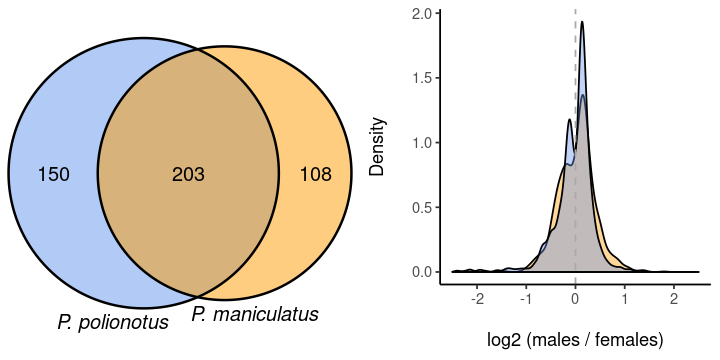

In [32]:
options(repr.plot.height=3,repr.plot.width=6)

plot_grid(venn,LFC, ncol=2,nrow=1)

##### By subregion

In [33]:
# significant in both species per subregion

sig.sex.shared.wo_pseudo.list <- list()

for(subregion in subregions){
    sig.sex.shared.wo_pseudo.list[[subregion]] <- intersect(
        names(m.can.ed.sex.sig.wo_pseudo[[paste0("BW_",subregion)]]), 
        names(m.can.ed.sex.sig.wo_pseudo[[paste0("PO_",subregion)]]))
}

In [34]:
# number of private and shared sex-biased genes per subregion

summary.table.sex_bias.sharing <- data.frame(matrix(nrow=length(subregions),ncol=5))
colnames(summary.table.sex_bias.sharing) <- c("subregion","total","shared","Pman-specific","Ppol-specific")
i=1
for (subregion in subregions){
    
    summary.table.sex_bias.sharing[i,1] <- subregion
    summary.table.sex_bias.sharing[i,2] <- length(names(m.can.ed.sex.sig.wo_pseudo[[subregion]]))
    summary.table.sex_bias.sharing[i,3] <- length(sig.sex.shared.wo_pseudo.list[[subregion]])
    summary.table.sex_bias.sharing[i,4] <- length(names(m.can.ed.sex.sig.wo_pseudo[[paste0("BW_",subregion)]]))-summary.table.sex_bias.sharing[i,3]
    summary.table.sex_bias.sharing[i,5] <- length(names(m.can.ed.sex.sig.wo_pseudo[[paste0("PO_",subregion)]]))-summary.table.sex_bias.sharing[i,3]
                                                  
    i=i+1
}

summary.table.sex_bias.sharing %>% mutate("perc_shared"=round(shared/total*100,2)) %>% arrange(perc_shared)

subregion,total,shared,Pman-specific,Ppol-specific,perc_shared
cerebellum,243,69,55,119,28.40
thalamus,242,69,104,69,28.51
septum,249,74,131,44,29.72
midbrain,219,68,95,56,31.05
mPFC,192,64,73,55,33.33
hippocampus,235,79,43,113,33.62
hypothalamus,254,86,69,99,33.86
hindbrain,216,79,51,86,36.57
striatum,203,81,70,52,39.90
amygdala,218,90,63,65,41.28


In [35]:
venn.plots <- gList()

for(subregion in subregions){
     
venn.plots[[subregion]] <- draw.pairwise.venn(length(names(m.can.ed.sex.sig.wo_pseudo[[paste0("BW_",subregion)]])), 
                            length(names(m.can.ed.sex.sig.wo_pseudo[[paste0("PO_",subregion)]])), 
                    length(sig.sex.shared.wo_pseudo.list[[subregion]]), #category=c("P. maniculatus","P. polionotus"), 
                    fill=c("P. maniculatus"="#FF9C00","P. polionotus"="#6495ED"),
                    cat.pos=c("P. maniculatus"=-12, "P. polionotus"=12), ind=F, cex=0.7, lwd=0.5,
                    cat.fontface=rep("italic",2), cat.fontfamily=rep("Helvetica",2), fontfamily=rep("Helvetica",3))            
}

In [36]:
# run second time to make sure species color assignment is consistent (not just by size of venn diagram part)
for(subregion in subregions[1:5]){
     
suppressWarnings(venn.plots[[subregion]] <- draw.pairwise.venn(length(names(m.can.ed.sex.sig.wo_pseudo[[paste0("BW_",subregion)]])), 
                                               length(names(m.can.ed.sex.sig.wo_pseudo[[paste0("PO_",subregion)]])), 
                    length(sig.sex.shared.wo_pseudo.list[[subregion]]), #category=c("P. maniculatus","P. polionotus"), 
                    fill=c("P. maniculatus"="#FF9C00","P. polionotus"="#6495ED"),
                    cat.pos=c("P. maniculatus"=-12, "P. polionotus"=12), ind=F, inverted=T, cex=0.7, lwd=0.5,
                    cat.fontface=rep("italic",2), cat.fontfamily=rep("Helvetica",2), fontfamily=rep("Helvetica",3)))
}

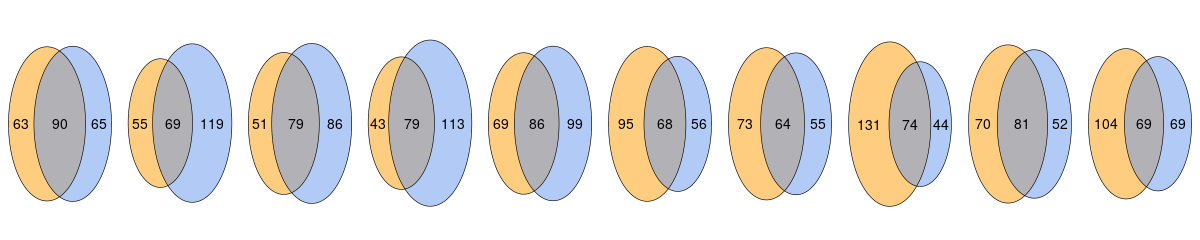

In [37]:
options(repr.plot.height=2,repr.plot.width=10)

venns <- plot_grid(plotlist=venn.plots, ncol=10, nrow=1, scale=0.9)
venns

file_name=paste0(plot_path,"out_RSEM.BW_PO.all_subregions.mashr.sex.DEcalls.venn.pdf")
if(!file.exists(file_name)) {
    save_plot(file_name, venns, ncol=10, nrow=1, base_height=1, base_width=1, scale=1)
}


In [38]:
options(repr.plot.height=3,repr.plot.width=3)

LFC.plots=gList()

for(subregion in subregions){
    
    LFC.plots[[subregion]] <- m.can.ed.sex.tall %>% separate(condition,into=c("species","tissue")) %>% 
        filter(gene %in% sig.sex.shared.wo_pseudo.list[[subregion]] & tissue==subregion) %>% 
        #filter(gene %in% names(m.can.ed.sex.sig.wo_pseudo[[subregion]]) & tissue==subregion) %>% 
        ggplot( aes(x=LFC, fill=species)) + 
            #geom_histogram(alpha=0.5,binwidth=0.1) + 
            geom_density(alpha=0.5, color=NA) + #, position ="stack") + 
            theme_classic() + geom_vline(aes(xintercept=0), linetype="dashed", color="black", size=0.25) +
            scale_fill_manual(values=c(BW="#FF9C00", PO="#6495ED")) + 
            theme(axis.title.y=element_blank()) +
            facet_wrap(~tissue, ncol=3) + theme(legend.position="none") +
            scale_x_continuous(breaks=c(-2,0,2), limits=c(-2.5,2.5)) + xlab("") +
            scale_y_continuous(breaks=c(0,1,2,3), limits=c(0,3)) + 
            theme(strip.background=element_blank(), strip.text.x=element_blank()) +
            theme(axis.line.y=element_blank(), axis.text.y=element_blank(), axis.ticks.y=element_blank()) +
            theme(axis.line.x=element_line(color="black"), axis.ticks.x=element_line(color="black"))
}

Warning message:
“Removed 3 rows containing non-finite values (stat_density).”Warning message:
“Removed 2 rows containing non-finite values (stat_density).”Warning message:
“Removed 2 rows containing non-finite values (stat_density).”Warning message:
“Removed 8 rows containing non-finite values (stat_density).”Warning message:
“Removed 2 rows containing non-finite values (stat_density).”Warning message:
“Removed 2 rows containing non-finite values (stat_density).”Warning message:
“Removed 2 rows containing non-finite values (stat_density).”Warning message:
“Removed 4 rows containing non-finite values (stat_density).”Warning message:
“Removed 2 rows containing non-finite values (stat_density).”Warning message:
“Removed 3 rows containing non-finite values (stat_density).”

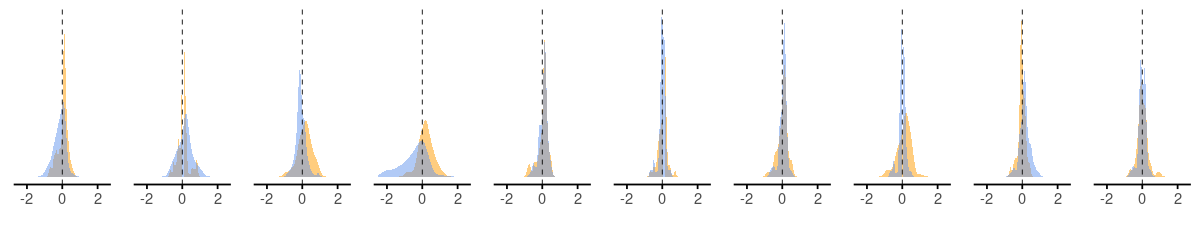

In [39]:
options(repr.plot.height=2,repr.plot.width=10)

LFCs <- plot_grid(plotlist=LFC.plots, ncol=10, nrow=1)
LFCs

file_name=paste0(plot_path,"out_RSEM.BW_PO.all_subregions.mashr.sex.DEcalls.LFCs.pdf")
if(!file.exists(file_name)) {
    save_plot(file_name, LFCs, ncol=10, nrow=1, base_height=1.5, base_width=1)
}

#### Plot posterior effect size estimates for individual genes

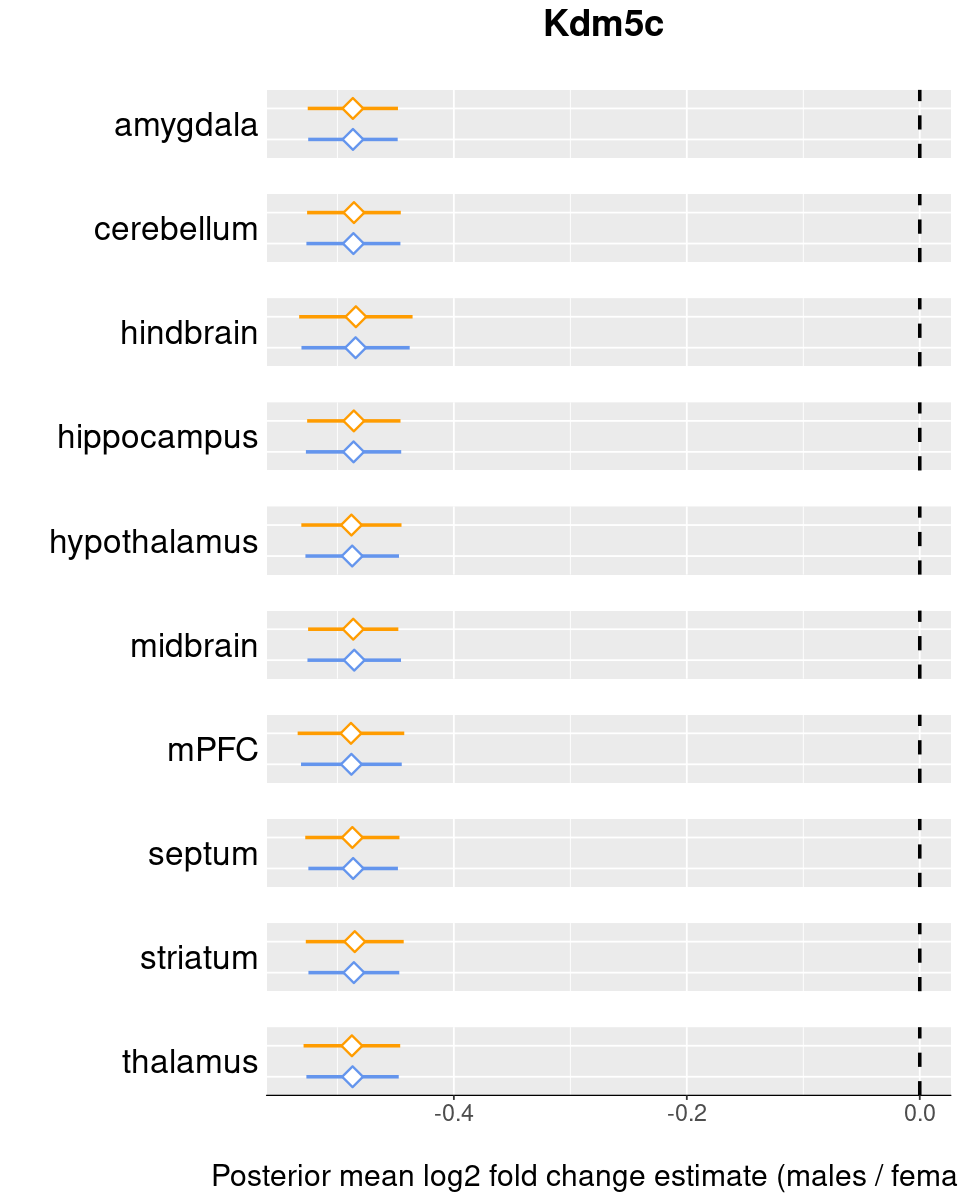

In [40]:
options(repr.plot.height=10,repr.plot.width=8)

gene="Kdm5c"

cbind(mean=m.can.ed.sex.NAs$result$PosteriorMean[gene,],SD=m.can.ed.sex.NAs$result$PosteriorSD[gene,]) %>% as.data.frame() %>%
    rownames_to_column("condition") %>% separate(condition,into=c("species","subregion"),sep="_",remove=F) %>%
    mutate(condition=fct_relevel(condition,rev(conditions))) %>%
    mutate(species=if_else(species=="BW","P. maniculatus","P. polionotus")) %>%
    ggplot( aes(x=fct_relevel(species,"P. polionotus","P. maniculatus"), y=mean, color=species)) + 
        geom_pointrange(aes(ymin=mean-1.96*SD, ymax=mean+1.96*SD, color=species), size=1, fill="white", shape=23) +
        coord_flip() + theme(legend.position="none") + #theme_classic() + 
        scale_color_manual(values=c("P. maniculatus"="#FF9C00","P. polionotus"="#6495ED")) +
        theme(axis.text.x=element_text(size=14), axis.text.y=element_blank(), axis.ticks.y=element_blank(),
              axis.line.y=element_blank(), axis.title=element_text(size=18), axis.line.x=element_line()) +
        theme(plot.title=element_text(color="black", size=22, face="bold", hjust=0.5)) +
        labs(title=paste(gene,"\n"), x="", y="\nPosterior mean log2 fold change estimate (males / females)") +
        #theme(legend.title=element_text(size=12), legend.text=element_text(size=10, face="italic")) + 
        facet_grid(rows=vars(subregion), switch="both") +
        theme(strip.text.y=element_text(size=20, colour="black", angle=180, hjust=1)) + 
        theme(strip.background=element_blank()) +
        theme(panel.spacing=unit(1.5, "lines")) +
        geom_hline(yintercept=c(0), col="black", linetype="dashed", lwd=1) + theme(legend.position="none")


file_name=paste0(plot_path,"out_RSEM.BW_PO.all_subregions.mashr.sex.mean_posterior_LFC.diff_facet.",gene,".pdf")
if(!file.exists(file_name)) {
    ggsave(file_name, height=10, width=8)
}

## Species-bias

### DESeq2 to estimate log fold change (effect size) + SE

In [41]:
for (subregion in subregions){

    rnaseqMatrix_sub <- input %>% select(matches(paste0("_",subregion))) %>% 
    na.omit() %>% round() %>% rownames_to_column("gene") %>%    
    filter(rowSums(cpm(select(.,-gene))>=1)>=3) %>% column_to_rownames("gene")
        
    input.meta_sub <- input.meta %>% filter(tissue == subregion) %>% droplevels()
    
    assign(paste0("dds_",subregion), DESeqDataSetFromMatrix(countData=rnaseqMatrix_sub, 
                                                    colData=input.meta_sub, design = ~species+sex+species:sex))
    assign(paste0("dds_",subregion), DESeq(get(paste0("dds_",subregion)), minReplicatesForReplace=5))
}


# run whole brain separately
# whole brain samples are males only -> model cannot include sex or species by sex interaction

subregion="wholebrain"

rnaseqMatrix_sub <- input %>% select(matches(paste0("_",subregion))) %>% 
na.omit() %>% round() %>% rownames_to_column("gene") %>%    
filter(rowSums(cpm(select(.,-gene))>=1)>=3) %>% column_to_rownames("gene")
    
input.meta_sub <- input.meta %>% filter(tissue == subregion) %>% droplevels()

assign(paste0("dds_",subregion), DESeqDataSetFromMatrix(countData=rnaseqMatrix_sub, 
                                                colData=input.meta_sub, design = ~species))
assign(paste0("dds_",subregion), DESeq(get(paste0("dds_",subregion)), minReplicatesForReplace=5))


for (subregion in subregions_WB){
    
# use DESeq's results function to pull out DE genes
    assign(paste0("res.species_",subregion), results(get(paste0("dds_",subregion)), alpha=0.05, 
                                             name="species_PO_vs_BW", pAdjustMethod="fdr"))

## don't use apeglm to shrink LFC values - will use multivariate adaptive shrinkage
#    assign(paste0("res.species.lfcShrink_",subregion), lfcShrink(get(paste0("dds_",subregion)), 
#                                        res=get(paste0("res.species_",subregion)), coef="species_PO_vs_BW", type="apeglm"))
    
# add subregion and species info
    assign(paste0("prep.species_",subregion), get(paste0("res.species_",subregion)) %>% as.data.frame() %>% 
           mutate("gene"=rownames(.)) %>% mutate("subregion"=subregion))

}

converting counts to integer mode
estimating size factors
estimating dispersions
gene-wise dispersion estimates
mean-dispersion relationship
final dispersion estimates
fitting model and testing
converting counts to integer mode
estimating size factors
estimating dispersions
gene-wise dispersion estimates
mean-dispersion relationship
final dispersion estimates
fitting model and testing
converting counts to integer mode
estimating size factors
estimating dispersions
gene-wise dispersion estimates
mean-dispersion relationship
final dispersion estimates
fitting model and testing
converting counts to integer mode
estimating size factors
estimating dispersions
gene-wise dispersion estimates
mean-dispersion relationship
final dispersion estimates
fitting model and testing
converting counts to integer mode
estimating size factors
estimating dispersions
gene-wise dispersion estimates
mean-dispersion relationship
final dispersion estimates
fitting model and testing
converting counts to integer m

### Compare expression across subregions

In [42]:
# combine all subregion data

for (subregion in subregions_WB){
    assign(paste0("genes_",subregion), get(paste0("dds_",subregion)) %>% rowData %>% as.data.frame() %>% 
           mutate("gene"=rownames(.)) %>% select(gene,baseMean) %>% mutate("subregion"=subregion))}

data.list = list()

for (subregion in subregions){
    data.list[[subregion]] <- get(paste0("genes_",subregion))} # add it to your list

# all genes in subregions (w/o whole brain)
all.genes <- do.call(rbind, data.list) %>% spread(subregion,baseMean) %>% anti_join(pseudogenes,by="gene") %>%
    mutate("shared"=rowSums(!is.na(select(.,-gene))), "average"=rowMeans(select(.,-gene), na.rm=T))

In [43]:
all.genes %>% group_by(shared) %>% tally() %>% mutate("percentage"=round(n/sum(n)*100,2))

nrow(all.genes)

shared,n,percentage
1,623,4.00
2,341,2.19
3,240,1.54
4,243,1.56
5,201,1.29
6,218,1.40
7,212,1.36
8,243,1.56
9,477,3.06
10,12769,82.03


[1] 15567

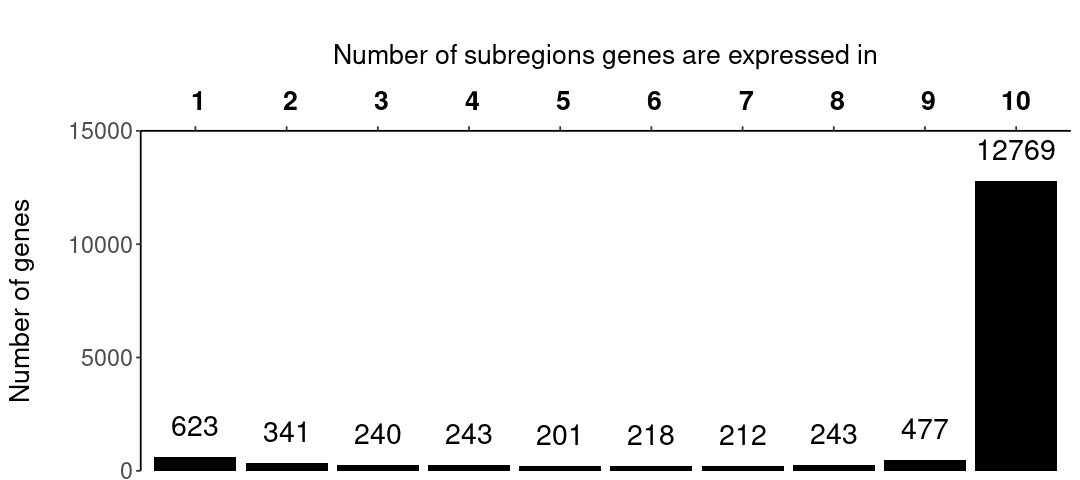

In [44]:
options(repr.plot.width=9, repr.plot.height=4)

all.genes %>% group_by(shared) %>% tally() %>%
    ggplot( aes(x=shared, y=n)) + geom_bar(stat="identity", fill="black") + theme_classic() +
    coord_cartesian(xlim=c(1,10), ylim=c(0,15000)) +
    labs(y="Number of genes\n", x="Number of subregions genes are expressed in\n", title="") + 
    #theme(plot.title=element_text(color="black", size=14, face="bold", hjust=0.5)) +
    theme(axis.title.y=element_text(size=16)) + theme(axis.text.y=element_text(size=14)) + 
    theme(axis.text.x.top=element_text(size=16, vjust=2.5, face="bold", color="black")) +
    theme(axis.title.x=element_text(size=16)) + 
    scale_x_discrete(limits=seq(1,10,1), position="top") + 
    scale_y_discrete(limits=c(0,5000,10000,15000)) +
    geom_text( aes(x=shared, y=n, label=n, vjust=-1), size=6)  

file_name=paste0(plot_path,"out_RSEM.BW_PO.all_subregions.shared_expression.pdf")
if(!file.exists(file_name)) {
    ggsave(file_name, width=9, height=4)
}

In [45]:
# how many genes expressed in whole brain, but not in any of the subregions?

private_WB <- genes_wholebrain %>% anti_join(pseudogenes, by="gene") %>% anti_join(all.genes, by="gene") %>% nrow()
private_WB

[1] 511

Warning message:
“funs() is soft deprecated as of dplyr 0.8.0
please use list() instead

  # Before:
  funs(name = f(.))

  # After: 
  list(name = ~ f(.))
This warning is displayed once per session.”

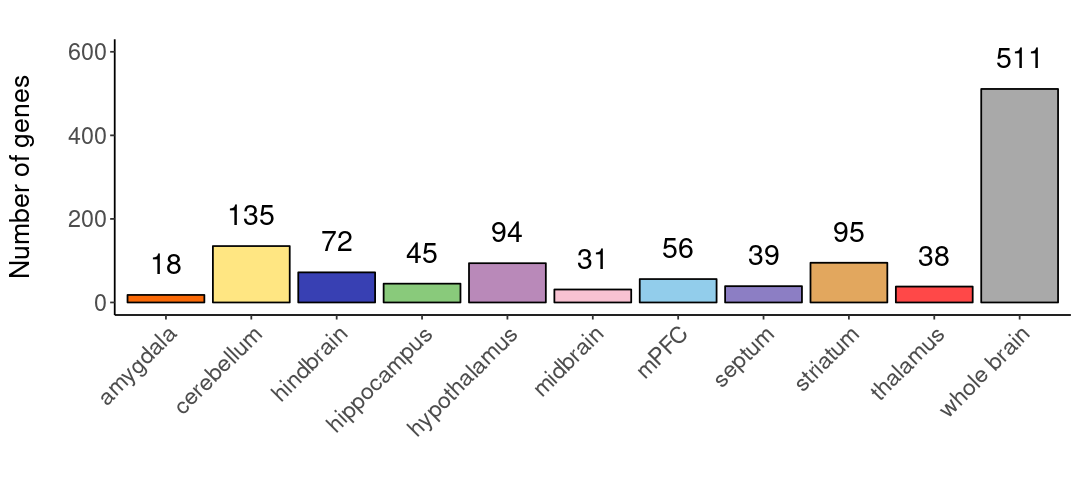

In [46]:
# genes specific to one subregion

all.genes %>% filter(shared==1) %>% select(-gene,-shared,-average) %>% summarise_all(funs(sum(!is.na(.)))) %>%
    gather(tissue) %>% rbind(c("whole brain",private_WB)) %>% mutate(value=as.numeric(value)) %>%
    ggplot( aes(x=tissue, y=value, fill=tissue)) + geom_bar(stat="identity", color="black") + theme_classic() +
        coord_cartesian(ylim=c(0,600)) + 
        labs(y="Number of genes\n", x="", title="") + 
        scale_fill_manual(values=c(amygdala="#FA6907", cerebellum="#FFE682",hindbrain="#3840B3",
        hippocampus="#89CA7B",hypothalamus="#B989B9",midbrain="#F8C2D2",mPFC="#92CDEB",septum="#8C7EC4",
        striatum="#E2A75E", thalamus="#FF4848","whole brain"="darkgray")) +
        #theme(plot.title=element_text(color="black", size=14, face="bold", hjust=0.5)) +
        theme(axis.text.x=element_text(size=14, angle=45, hjust=1), axis.text.y=element_text(size=14)) +
        theme(axis.title=element_text(size=16)) +
        geom_text( aes(x=tissue, y=value, label=value, vjust=-1), size=6) +
        theme(legend.position="none")

file_name=paste0(plot_path,"out_RSEM.BW_PO.all_subregions_withWB.private_expression.pdf")
if(!file.exists(file_name)) {
    ggsave(file_name, width=9, height=4)
}

#### Enrichment analyses

In [47]:
# assign genes to foreground and background based number of subregions they are expressed in

gene_list="private"

enrich.matrix.expr <- all.genes %>% mutate("foreground"=if_else(shared == 1, "1", "0")) %>% arrange(gene)

enrich.matrix.expr %>% group_by(foreground) %>% tally()

enrich.BGlist.expr <- enrich.matrix.expr %>% select(gene) %>% unlist() %>% as.vector()
enrich.FGlist.expr <- enrich.matrix.expr %>% filter(foreground=="1") %>% select(gene) %>% unlist() %>% as.vector()

# write to file
file_name.BG.expr = paste0(plot_path,"out_RSEM.BW_PO.all_subregions.mashr.expr.",gene_list,".bg.genelist.txt")
file_name.FG.expr = paste0(plot_path,"out_RSEM.BW_PO.all_subregions.mashr.expr.",gene_list,".fg.genelist.txt")

if(!file.exists(file_name.BG.expr)) {
    write_tsv(as.data.frame(enrich.BGlist.expr), file_name.BG.expr, col_names=F) 
    write_tsv(as.data.frame(enrich.FGlist.expr), file_name.FG.expr, col_names=F)
}

foreground,n
0,14944
1,623


In [48]:
enrichResult.expr <- WebGestaltR(enrichMethod="ORA", organism="mmusculus", hostName="https://www.webgestalt.org/",
    enrichDatabase=c("geneontology_Biological_Process_noRedundant","geneontology_Cellular_Component_noRedundant",
                         "geneontology_Molecular_Function_noRedundant","phenotype_Mammalian_Phenotype_Ontology",
                            "pathway_KEGG","pathway_Panther","pathway_Reactome"),
    enrichDatabaseType="entrezgene",
    interestGene=enrich.FGlist.expr, interestGeneType="genesymbol", 
    referenceGene=enrich.BGlist.expr, referenceGeneType="genesymbol", 
    minNum=5, maxNum=2000, sigMethod="fdr", fdrMethod="BH", fdrThr=0.05, reportNum=1000, 
    dagColor="continuous", isOutput=T, outputDirectory=plot_path, setCoverNum=10,
    projectName=paste0("out_WebGestaltR.mashr.expr.",gene_list)) 

Loading the functional categories...
Loading the ID list...
Loading the reference list...


Warning message in dir.create(projectDir):
“'/n/hoekstra_lab_tier1/Users/akautt/projects/Peromyscus_RNAseq_brain/results_plots_tables//Project_out_WebGestaltR_mashr_expr_private' already exists”

Summarizing the input ID list by GO Slim data...
Performing the enrichment analysis...
Begin affinity propagation...
End affinity propagation...
Begin weighted set cover...
End weighted set cover...
Generate the final report...


Warning message in system2(zip, args):
“error in running command”

Results can be found in the /n/hoekstra_lab_tier1/Users/akautt/projects/Peromyscus_RNAseq_brain/results_plots_tables//Project_out_WebGestaltR_mashr_expr_private!


### mashr

In [49]:
# combine subregion species results

data.list = list()

for (subregion in subregions_WB){
    data.list[[subregion]] <- get(paste0("prep.species_",subregion))}

all.species <- do.call(rbind, c(data.list))

In [50]:
# create two matrices, one with effect and one with SE for mashr
# NOTE: set missing LFCs to 0 and missing lfcSEs to 1000 - missing data not allowed in mashr

all.species.LFC <- all.species %>% select(gene,subregion,log2FoldChange) %>% 
    spread(subregion,log2FoldChange) %>% column_to_rownames("gene") %>% replace(., is.na(.), 0) %>% as.matrix()

all.species.SE <- all.species %>% select(gene,subregion,lfcSE) %>% 
    spread(subregion,lfcSE) %>% column_to_rownames("gene") %>% replace(., is.na(.), 1000) %>% as.matrix()

# create same-sized matrix with "1"s and NAs to fill NAs back into final data frame via matrix multiplication later

all.species.NAs <- all.species %>% select(gene,subregion,lfcSE) %>% 
    spread(subregion,lfcSE) %>% mutate_if(is.numeric, ~if_else(!is.na(.), 1, .)) %>% 
    column_to_rownames("gene") %>% as.matrix()

#### Sparse factor analysis (SFA)

In [51]:
# create matrix of Z-scores (effect divided by SE) for SFA

all.species.lfcZ <- all.species %>% mutate("lfcZ"=log2FoldChange/lfcSE) %>% 
    select(gene,subregion,lfcZ) %>% spread(subregion,lfcZ) %>% column_to_rownames("gene") %>% 
    replace(., is.na(.), 0) %>% as.data.frame()


# write to file
file_name=paste0(plot_path,"out_RSEM.BW_PO.all_subregions_withWB.species.lfcZ.forSFA.tsv")
if(!file.exists(file_name)) {
    write_tsv(all.species.lfcZ, file_name, col_names=F)
}

cat("SFA n =",ncol(all.species.lfcZ),"\nSFA g =",nrow(all.species.lfcZ))

SFA n = 11 
SFA g = 16666

In [52]:
# system call to run sparse factor analysis (SFA) externally
# adjust n and g and choose k = number of clusters

no_SFs=5

if(!file.exists(file.path(plot_path,"out_SFA.all_subregion_withWB.species.lfcZ.k5_F.out"))) {

    system(sprintf("module load gsl; ~/software/sfa_1.0/bin/sfa_linux \\
    -gen /n/hoekstra_lab_tier1/Users/akautt/projects/Peromyscus_RNAseq_brain/results_plots_tables/out_RSEM.BW_PO.all_subregions_withWB.species.lfcZ.forSFA.tsv \\
    -t -n 11 -g 16666 -k %s -iter 20 -rand 5 \\
    -o /n/hoekstra_lab_tier1/Users/akautt/projects/Peromyscus_RNAseq_brain/results_plots_tables/out_SFA.all_subregion_withWB.species.lfcZ.k5", no_SFs),
    intern=F)
}

sf.species = as.matrix(read.delim(file.path(plot_path,"out_SFA.all_subregion_withWB.species.lfcZ.k5_F.out"),header=F))
sf.species

V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11
0.820564,-0.256009000,1.72230,0.591810,0.0835146,0.30200700,-0.1834650,-0.037861,0.0947316,-0.0440670,-2.61180
0.720985,-0.216262000,1.85365,0.373680,-0.2985300,0.00125375,-0.0518652,-0.184370,-1.2423600,-0.0163586,-2.31521
-0.941648,0.000848466,2.73409,0.442429,-0.0918969,0.01919420,-0.1952790,-0.143987,-0.1654820,-0.1898880,-1.52033
0.467678,-0.283472000,2.39185,0.172997,-0.1001300,0.06510810,-0.2205320,-0.225035,-0.3803520,-1.2663500,-1.79242
-0.477597,0.389556000,-2.37767,-0.229123,0.1051690,-0.18037800,0.5551930,-0.230292,0.6026270,-0.0042733,2.03705


#### Create covariance matrices

In [53]:
# create mashr data object
mashr.species.data = mash_set_data(all.species.LFC, all.species.SE)

# add correlations - https://stephenslab.github.io/mashr/articles/intro_correlations.html
V.species = estimate_null_correlation_simple(mashr.species.data)
mashr.species.data.V = mash_update_data(mashr.species.data, V=V.species)

# generate canoncial covariance matrices
U.can.species = cov_canonical(mashr.species.data)

# run ashr across all conditions and extract strong effects - use as initial conditions for ED
m.1by1.species = mash_1by1(mashr.species.data)
strong.species = get_significant_results(m.1by1.species, 0.05)

# generate PCA-based covariance matrices
no_PCs=5
U.pca.species = cov_pca(mashr.species.data, no_PCs, subset=strong.species)

# generate SFA-based covariance matrices
U.sfa.species = cov_from_factors(sf.species, name = c(sprintf("SFA_%02d", seq(1,no_SFs))))

# generate extreme deconvolution-based covariance matrices based on PCA and SFA
U.ed.species = cov_ed(mashr.species.data, c(U.pca.species,U.sfa.species), subset=strong.species)

#### Run mashr

In [54]:
# only canonical
m.can.species = mash(mashr.species.data.V, c(U.can.species), algorithm.version="Rcpp", 
                 verbose=T, add.mem.profile=T, outputlevel=2)

 - Computing 16666 x 465 likelihood matrix.
 - Likelihood calculations allocated 629.40 MB and took 16.01 seconds.
 - Fitting model with 465 mixture components.
 - Model fitting allocated 658.53 MB and took 14.23 s.
 - Computing posterior matrices.
 - Computation allocated 86.42 MB and took 195.60 s.


In [55]:
# only extreme deconvolution - only works with normalizeU=F
m.ed.species = mash(mashr.species.data.V, c(U.ed.species), algorithm.version="Rcpp", 
                 normalizeU=F, verbose=T, add.mem.profile=T, outputlevel=2)

 - Computing 16666 x 320 likelihood matrix.
 - Likelihood calculations allocated 435.45 MB and took 13.08 seconds.
 - Fitting model with 320 mixture components.
 - Model fitting allocated 453.88 MB and took 10.25 s.
 - Computing posterior matrices.
 - Computation allocated 87.19 MB and took 241.78 s.


In [56]:
# canonical and extreme deconvolution - only works with normalizeU=F
m.can.ed.species = mash(mashr.species.data.V, c(U.can.species,U.ed.species), algorithm.version="Rcpp", 
                 normalizeU=F, verbose=T, add.mem.profile=T, outputlevel=2)

 - Computing 16666 x 784 likelihood matrix.
 - Likelihood calculations allocated 1055.88 MB and took 23.71 seconds.
 - Fitting model with 784 mixture components.
 - Model fitting allocated 1110.81 MB and took 30.40 s.
 - Computing posterior matrices.
 - Computation allocated 89.91 MB and took 368.10 s.


In [57]:
# compare log-likelihoods
cat("m.can.species:",get_loglik(m.can.species),"\n")
cat("m.ed.species:",get_loglik(m.ed.species),"\n")
cat("m.can.ed.species:",get_loglik(m.can.ed.species))

m.can.species: -209088.8 
m.ed.species: -226077.6 
m.can.ed.species: -203621.6

### Analyses

In [58]:
# fill NAs as 0 for effect size and SD and 1 for lfsr for genes that were too lowly expressed back in
# mashr will sometimes adjust effect size from zero to something, which is not sensible for genes that are not expressed in a certain region

# check if gene names and order are identical
all.equal(rownames(m.can.ed.species$result$PosteriorMean), rownames(all.species.NAs))

m.can.ed.species.NAs <- m.can.ed.species
m.can.ed.species.NAs$result$PosteriorMean <- (m.can.ed.species$result$PosteriorMean * all.species.NAs) %>% replace_na(0)
m.can.ed.species.NAs$result$PosteriorSD <- (m.can.ed.species$result$PosteriorSD * all.species.NAs) %>% replace_na(0)
m.can.ed.species.NAs$result$lfsr <- (m.can.ed.species$result$lfsr * all.species.NAs) %>% replace_na(1)

# write to file
file_name=paste0(plot_path,"/out_mashr.RSEM.BW_PO.all_subregions_withWB.species.rda")
if(!file.exists(file_name)) {
    save(m.can.ed.species.NAs, file=file_name)
}

[1] TRUE

In [ ]:
# load from file
attach(paste0(plot_path,"/out_mashr.RSEM.BW_PO.all_subregions_withWB.species.rda"))

In [59]:
# reshape mashr results into one data.frame

m.can.ed.species.tall <- full_join(m.can.ed.species.NAs$result$PosteriorMean %>% as.data.frame() %>% 
    rownames_to_column("gene") %>% gather("subregion","LFC",-gene), 
                                m.can.ed.species.NAs$result$PosteriorSD %>% as.data.frame() %>%  
    rownames_to_column("gene") %>% gather("subregion","SD",-gene), by=c("gene","subregion")) %>%
                        full_join(m.can.ed.species.NAs$result$lfsr %>% as.data.frame() %>%  
    rownames_to_column("gene") %>% gather("subregion","lfsr",-gene), by=c("gene","subregion"))


# write to file
file_name=paste0(plot_path,"/out_mashr.RSEM.BW_PO.all_subregions_withWB.species.tsv")
if(!file.exists(file_name)) {
    write_tsv(m.can.ed.species.tall, file_name)
}

#### Summary

In [60]:
# pull out vectors of significant genes...

m.can.ed.species.sig <- list()

# in at least one condition
m.can.ed.species.sig$all <- get_significant_results(m.can.ed.species.NAs, thresh=0.05, sig_fn=get_lfsr, conditions=NULL)

# in every single subregion
for (subregion in subregions_WB){
     m.can.ed.species.sig[[subregion]] <- get_significant_results(m.can.ed.species.NAs, thresh=0.05, 
                                                        sig_fn=get_lfsr, conditions=subregion)}

In [61]:
# remove pseudogenes

m.can.ed.species.sig.wo_pseudo <- lapply(m.can.ed.species.sig, function(x){
    x[!names(x) %in% pseudogenes$gene %>% as.vector()]
})

In [62]:
# number of DE genes per subregion

summary.table.species <- data.frame(matrix(nrow=length(subregions),ncol=7))
colnames(summary.table.species) <- c("subregion","total.expressed","total.DE","perc.DE","Pman.biased","Ppol.biased","binom.p")
i=1
for (subregion in subregions_WB){
    
    summary.table.species[i,1] <- subregion
    summary.table.species[i,2] <- all.species.NAs %>% as.data.frame() %>% select(subregion) %>% na.omit() %>%
            rownames_to_column("gene") %>% anti_join(pseudogenes, by="gene") %>% nrow()
    summary.table.species[i,3] <- length(m.can.ed.species.sig.wo_pseudo[[subregion]])
    summary.table.species[i,4] <- round((summary.table.species[i,3]/summary.table.species[i,2])*100,2)
    summary.table.species[i,5] <- m.can.ed.species.NAs$result$PosteriorMean[m.can.ed.species.sig.wo_pseudo[[subregion]],subregion] %>% 
            as.data.frame() %>% summarise(upBW=sum(.<0))
    summary.table.species[i,6] <- m.can.ed.species.NAs$result$PosteriorMean[m.can.ed.species.sig.wo_pseudo[[subregion]],subregion] %>% 
            as.data.frame() %>% summarise(upPO=sum(.>0))
    summary.table.species[i,7] <- round(binom.test(summary.table.species[i,5],summary.table.species[i,3],
                                         p=0.5, alternative="two.sided", conf.level=0.95)$p.value, 3)
    i=i+1
}
summary.table.species$binom.padj <- round(p.adjust(summary.table.species$binom.p, method="holm"), 4)
summary.table.species %>% mutate("significant"=if_else(binom.padj<0.05,"yes","no"))

cat("Total number of significant genes (across all regions): ", length(m.can.ed.species.sig.wo_pseudo$all), "\n")
cat("Total number of expressed/analyzed genes (across all regions): ", 
    all.species.NAs %>% as.data.frame() %>% rownames_to_column("gene") %>% anti_join(pseudogenes, by="gene") %>% nrow(), "\n")

subregion,total.expressed,total.DE,perc.DE,Pman.biased,Ppol.biased,binom.p,binom.padj,significant
amygdala,14129,7499,53.08,3691,3808,0.180,1.000,no
cerebellum,13755,7792,56.65,3917,3875,0.642,1.000,no
hindbrain,14219,8085,56.86,4108,3977,0.148,1.000,no
hippocampus,14003,7764,55.45,3839,3925,0.335,1.000,no
hypothalamus,14429,8173,56.64,4045,4128,0.364,1.000,no
midbrain,14140,8327,58.89,4200,4127,0.430,1.000,no
mPFC,13878,7217,52.00,3558,3659,0.239,1.000,no
septum,14175,7431,52.42,3686,3745,0.501,1.000,no
striatum,14073,7875,55.96,3833,4042,0.019,0.209,no
thalamus,13920,8255,59.30,4124,4131,0.947,1.000,no


Total number of significant genes (across all regions):  12624 
Total number of expressed/analyzed genes (across all regions):  16078 


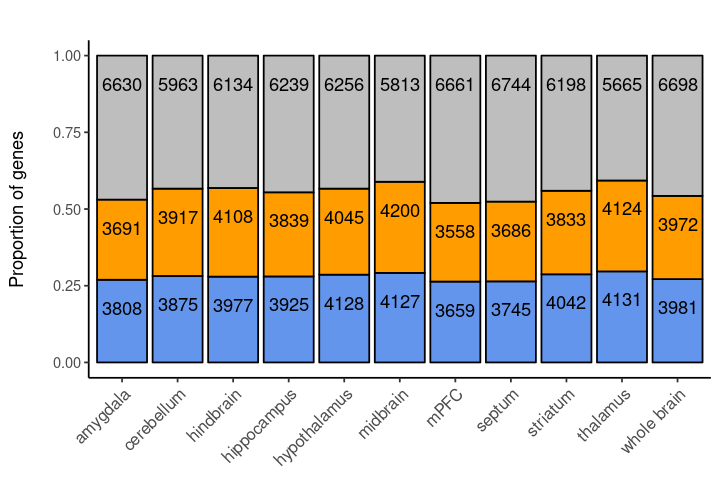

In [63]:
options(repr.plot.width=6, repr.plot.height=4)

summary.table.species %>% select(subregion,total.expressed,Pman.biased,Ppol.biased) %>%
    mutate(subregion=replace(subregion,subregion=="wholebrain","whole brain")) %>%
    mutate("nonDE"=total.expressed-Pman.biased-Ppol.biased) %>%
    select(-total.expressed) %>%
    gather(key="category",value="n",-subregion) %>% group_by(subregion) %>%
    mutate(prop=n/sum(n)) %>%
    ggplot( aes(x=subregion, y=prop, fill=category)) + 
            geom_bar(stat="identity", color="black", position="stack") + theme_classic() + 
            labs(y="Proportion of genes\n", x="Region", title="") + 
            scale_fill_manual(values=c(nonDE="grey", Pman.biased="#FF9C00", Ppol.biased="#6495ED"), 
            labels=c(nonDE="non-significant",Pman.biased="DE - higher in P. maniculatus",Ppo.biased="DE - higher in P. polionotus"), name="Differential expression (DE) call") + 
            theme(plot.title=element_text(color="black", size=14, face="bold", hjust=0.5)) +
            theme(axis.text.x=element_text(angle=45, hjust=1, size=10)) + theme(axis.title.x=element_blank()) +
            geom_text(aes(label=n), position = "stack", hjust=0.5, vjust=2.5) + 
            theme(legend.position = "none")

file_name=paste0(plot_path,"out_RSEM.BW_PO.all_subregions_withWB.mashr.species.DEcalls.rel.pdf")
if(!file.exists(file_name)) {
    ggsave(file_name, width=6, height=4)
}

#### Intersect with Young et al monogamy-related gene list

In [64]:
focal.list <- Young_monogamy_genes %>% unlist() %>% as.vector()

monogamy.overlap <- intersect(m.can.ed.species.tall %>% select(gene) %>% unlist() %>% as.vector(), focal.list)

monogamy.match <- intersect(names(m.can.ed.species.sig$all), focal.list)

cat("Number of genes in gene list: ", length(focal.list))
cat("\n\nNumber of genes in our data: ", length(monogamy.overlap))

Number of genes in gene list:  42

Number of genes in our data:  38

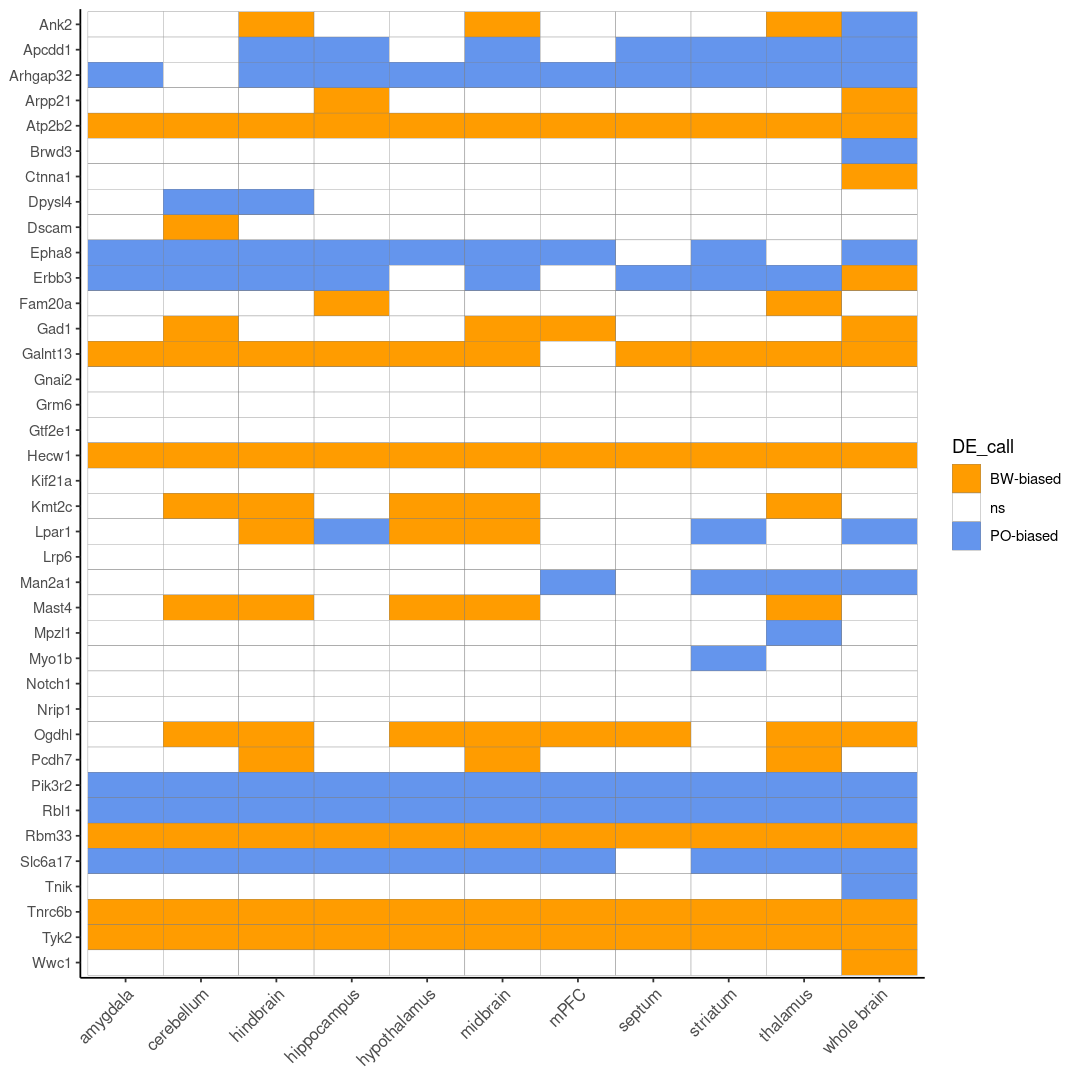

In [65]:
options(repr.plot.width=9, repr.plot.height=9)

m.can.ed.species.tall %>% filter(gene %in% focal.list) %>%  
    mutate(subregion = str_replace(subregion, "wholebrain", "whole brain")) %>%
    mutate("DE_call"=
        case_when(lfsr >= 0.05 ~ "ns",
                lfsr < 0.05 & LFC < 0 ~ "BW-biased",
                lfsr < 0.05 & LFC > 0 ~ "PO-biased")) %>%
    select(gene,subregion,DE_call) %>%
    ggplot( aes(subregion, reorder(gene, desc(gene)), fill=DE_call)) +
        geom_tile(color="gray50") + theme_classic() + 
        scale_fill_manual(values=c("ns"="white", "BW-biased"="#FF9C00", "PO-biased"="#6495ED")) + 
        theme(axis.text.x=element_text(angle=45, hjust=1, size=10)) + 
        theme(axis.title.x=element_blank()) + theme(axis.title.y=element_blank())

file_name=paste0(plot_path,"/out_RSEM.BW_PO.all_subregions_withWB.species.DEcalls.monogamy_genes.pdf")
if(!file.exists(file_name)) {
    ggsave(file_name, width=9, height=9)}

#### Heatmap of lfc across subregions

In [66]:
# assign genes to foreground and background based on lfsr and LFC

matrix.species <- m.can.ed.species.tall %>% 
    anti_join(pseudogenes, by="gene") %>%
    mutate("foreground"=if_else(lfsr < 0.05 & abs(LFC) >= 1.0, "1",
                   if_else(lfsr < 0.05 & abs(LFC) < 1.0, "0",
                       if_else(lfsr >= 0.05, "0", "")))) %>% mutate(foreground=as.numeric(foreground)) %>%
    select(gene,subregion,foreground) %>% spread(subregion,foreground) %>%
    mutate("foreground"=if_else(rowSums(select(.,-gene),na.rm=T) >=1, "1", "0")) %>% arrange(gene)

matrix.species %>% group_by(foreground) %>% tally()

focal_list <- matrix.species %>% filter(foreground=="1") %>% select(gene) %>% unlist() %>% as.vector()

foreground,n
0,13159
1,2919


In [67]:
# pull out significant DE genes with |LFC| > 2
pheat.input.species <- m.can.ed.species.NAs$result$PosteriorMean[focal_list,] %>% as.data.frame() %>%
        rename("whole brain"=wholebrain)   

out.pheat.species <- pheatmap(pheat.input.species, silent=T, clustering_method="mcquitty")

cat("number of retained genes: ", nrow(pheat.input.species))

number of retained genes:  2919

In [68]:
# redefine colors and breaks to be centered around zero
nHalf <- 50
Min <- -5 #x-max(abs(min(pheat.input.species)),max(pheat.input.species))
Max <- 5 #max(abs(min(pheat.input.species)),max(pheat.input.species))
Thresh <- 0

# make vector of colors for values above and below threshold and zero
rc1 <- colorRampPalette(colors = c("#FF9C00", "white"), space="Lab")(nHalf)    
rc2 <- colorRampPalette(colors = c("white", "#6495ED"), space="Lab")(nHalf)
rampcols <- c(rc1, rc2)
rampcols[nHalf] <- rgb(t(col2rgb("white")), maxColorValue=256)

rb1 <- seq(Min, Thresh, length.out=nHalf+1)
rb2 <- seq(Thresh, Max, length.out=nHalf+1)[-1]
rampbreaks <- c(rb1, rb2)

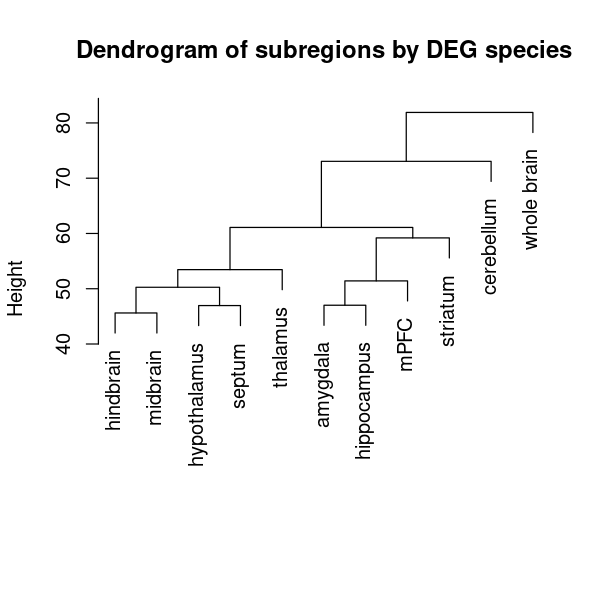

In [69]:
options(repr.plot.width=5, repr.plot.height=5)

sort_hclust <- function(...) as.hclust(dendsort(as.dendrogram(...)))

mat_cluster_cols.species <- sort_hclust(out.pheat.species$tree_col)
mat_cluster_rows.species <- sort_hclust(out.pheat.species$tree_row)

plot(mat_cluster_cols.species, main = "Dendrogram of subregions by DEG species", xlab = "", sub = "")

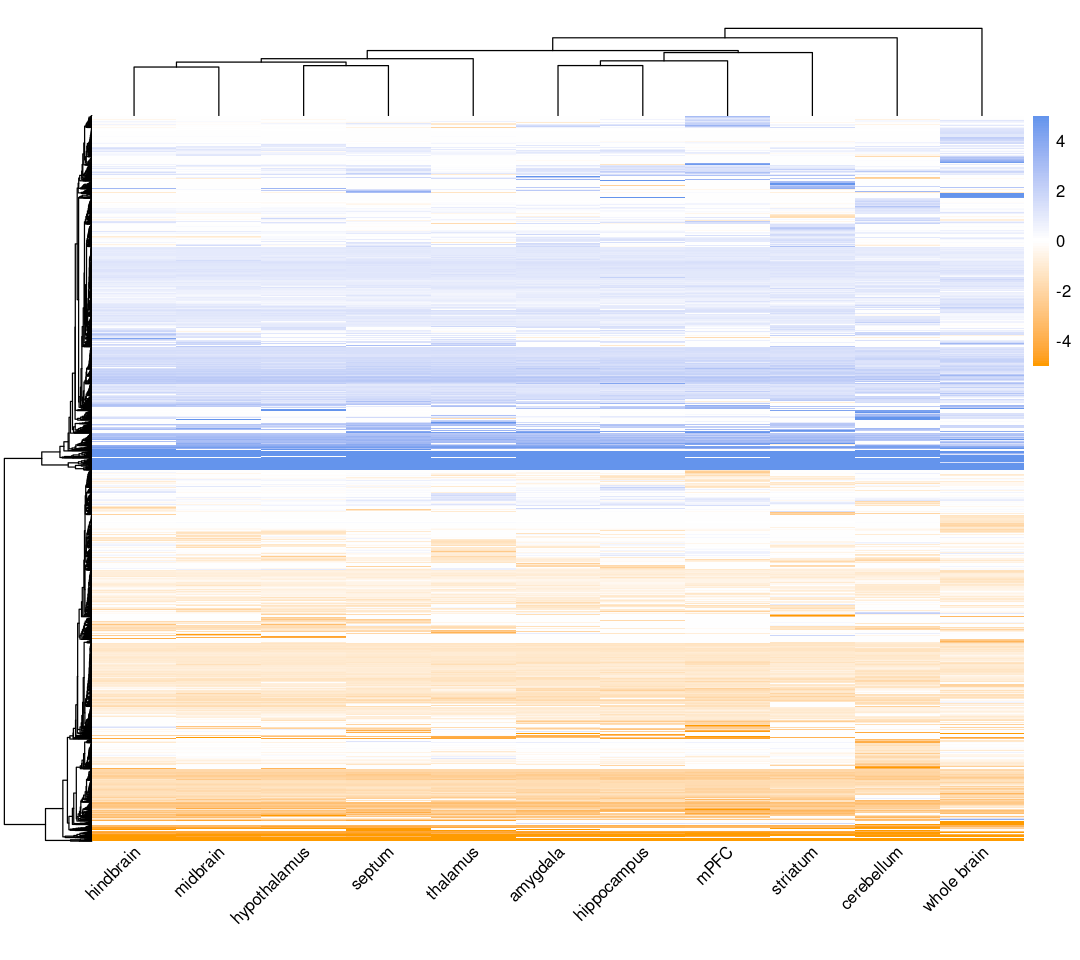

In [70]:
options(repr.plot.width=9, repr.plot.height=8)

pheatmap(pheat.input.species, scale="none", color=rampcols, breaks=rampbreaks, border_color="grey60", display_numbers=F, 
        show_colnames=T, main="", cluster_cols=mat_cluster_cols.species, 
        cluster_rows=mat_cluster_rows.species,
        show_rownames=F) #, clustering_method="mcquitty")

file_name=paste0(plot_path,"/out_RSEM.BW_PO.all_subregions_withWB.mashr.species.lfsr0.05.LFC1.maxLFC5.heatmap.pdf")
if(!file.exists(file_name)) {

    pheatmap(pheat.input.species, scale="none", color=rampcols, breaks=rampbreaks, border_color="grey60", display_numbers=F, 
        show_colnames=T, main="", cluster_cols=mat_cluster_cols.species, 
        cluster_rows=mat_cluster_rows.species, show_rownames=F, filename=file_name)
}

In [71]:
# ...above with sign flip across subregions
pheat.input.species <- m.can.ed.species.NAs$result$PosteriorMean[focal_list,] %>% as.data.frame() %>%
    rename("whole brain"=wholebrain) %>%
    rownames_to_column("gene") %>%
    anti_join(pseudogenes, by="gene") %>%
    mutate("signflip"=if_else(rowSums(select(.,-gene)>0) > 0 & rowSums(select(.,-gene)<0) > 0, "1","0")) %>% 
    filter(signflip==1) %>% select(-signflip) %>% column_to_rownames("gene")

out.pheat.species <- pheatmap(pheat.input.species, silent=T, clustering_method="mcquitty")

cat("number of retained genes: ", nrow(pheat.input.species))

number of retained genes:  628

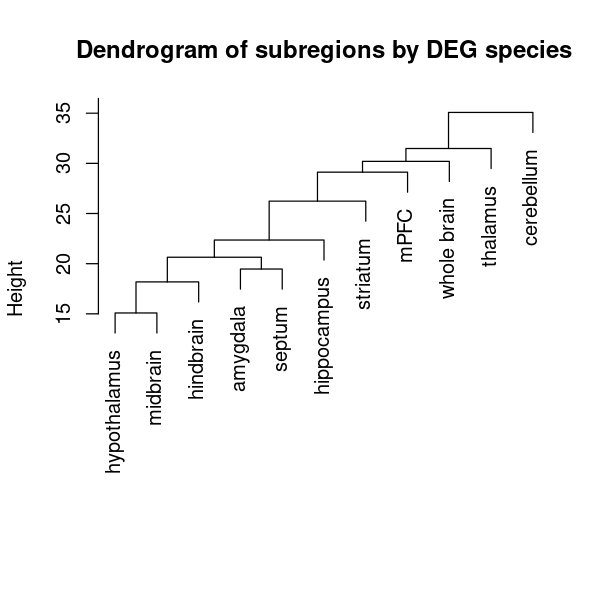

In [72]:
options(repr.plot.width=5, repr.plot.height=5)

sort_hclust <- function(...) as.hclust(dendsort(as.dendrogram(...)))

mat_cluster_cols.species <- sort_hclust(out.pheat.species$tree_col)
mat_cluster_rows.species <- sort_hclust(out.pheat.species$tree_row)

plot(mat_cluster_cols.species, main = "Dendrogram of subregions by DEG species", xlab = "", sub = "")

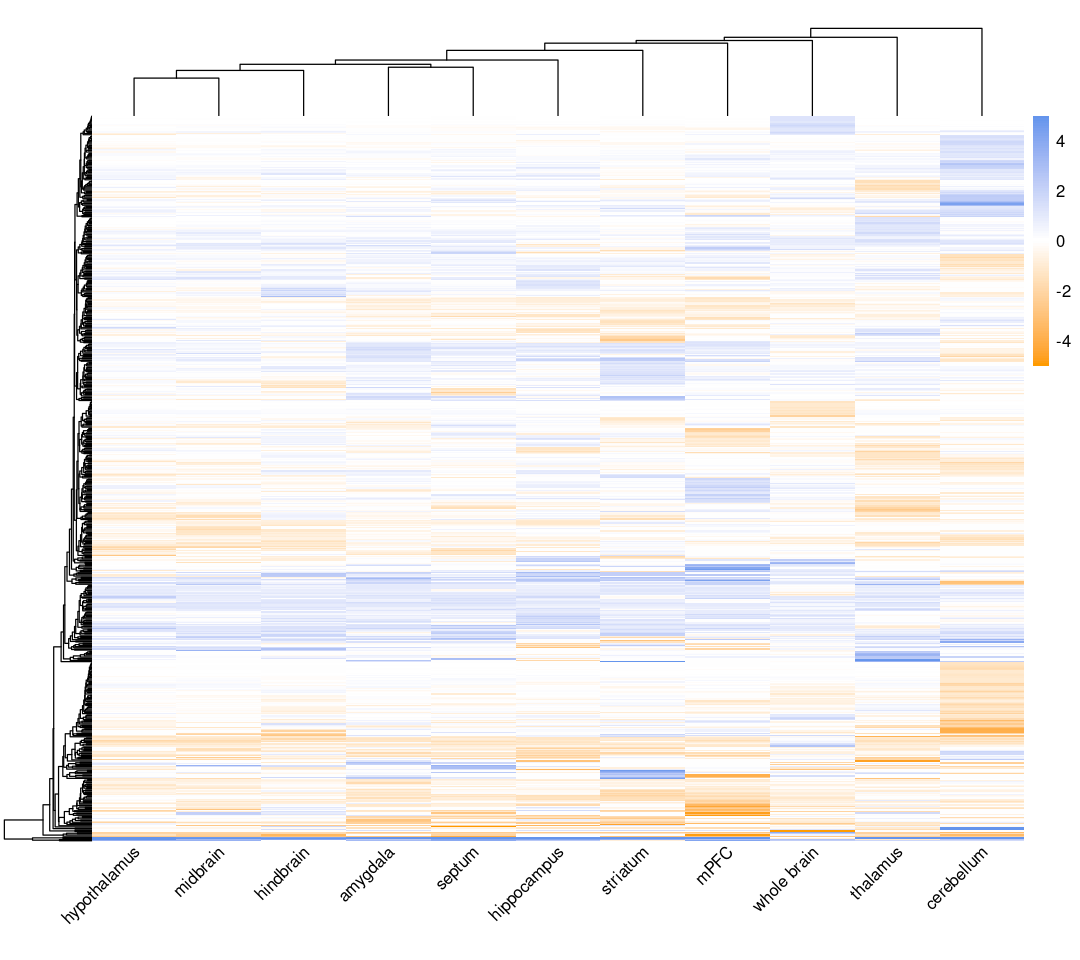

In [73]:
options(repr.plot.width=9, repr.plot.height=8)

pheatmap(pheat.input.species, scale="none", color=rampcols, breaks=rampbreaks, border_color="grey60", display_numbers=F, 
        show_colnames=T, main="", cluster_cols=mat_cluster_cols.species, 
        cluster_rows=mat_cluster_rows.species,
        show_rownames=F)

file_name=paste0(plot_path,"/out_RSEM.BW_PO.all_subregions_withWB.mashr.species.lfsr0.05.LFC1.maxLFC5.sign_flip.heatmap.pdf")
if(!file.exists(file_name)) {

    pheatmap(pheat.input.species, scale="none", color=rampcols, breaks=rampbreaks, border_color="grey60", display_numbers=F, 
        show_colnames=T, main="", cluster_cols=mat_cluster_cols.species, 
        cluster_rows=mat_cluster_rows.species, show_rownames=F, filename=file_name)
}

#### Sharing

In [74]:
# sharing 

# only significant, same sign, and within a factor 0.5 of each other
sharing.species.lfsr0.05.fact0.5.ident <- get_pairwise_sharing(m.can.ed.species.NAs, factor=0.5, lfsr_thresh=0.05, FUN=identity)

# all significant, same sign
sharing.species.lfsr0.05.fact0.ident <- get_pairwise_sharing(m.can.ed.species.NAs, factor=0, lfsr_thresh=0.05, FUN=identity)

In [75]:
cor_mat <- sharing.species.lfsr0.05.fact0.5.ident

reorder_cormat <- function(cormat){
    dd <- as.dist((1-cormat)/2)
    hc <- hclust(dd, method="mcquitty")
    cormat <- cormat[hc$order, hc$order]
}

# pull out order of traits based on clustering
region_order <- rownames(reorder_cormat(cor_mat))

cor_mat_plot <- reorder_cormat(cor_mat) %>% as.data.frame() %>% rownames_to_column(var="region1") %>%
    gather(key="region2", value="r", -region1) %>%
    mutate(region1=fct_relevel(region1, levels=region_order)) %>%
    mutate(region2=fct_relevel(region2, levels=region_order))

Warning message:
“Outer names are only allowed for unnamed scalar atomic inputs”Warning message:
“Outer names are only allowed for unnamed scalar atomic inputs”

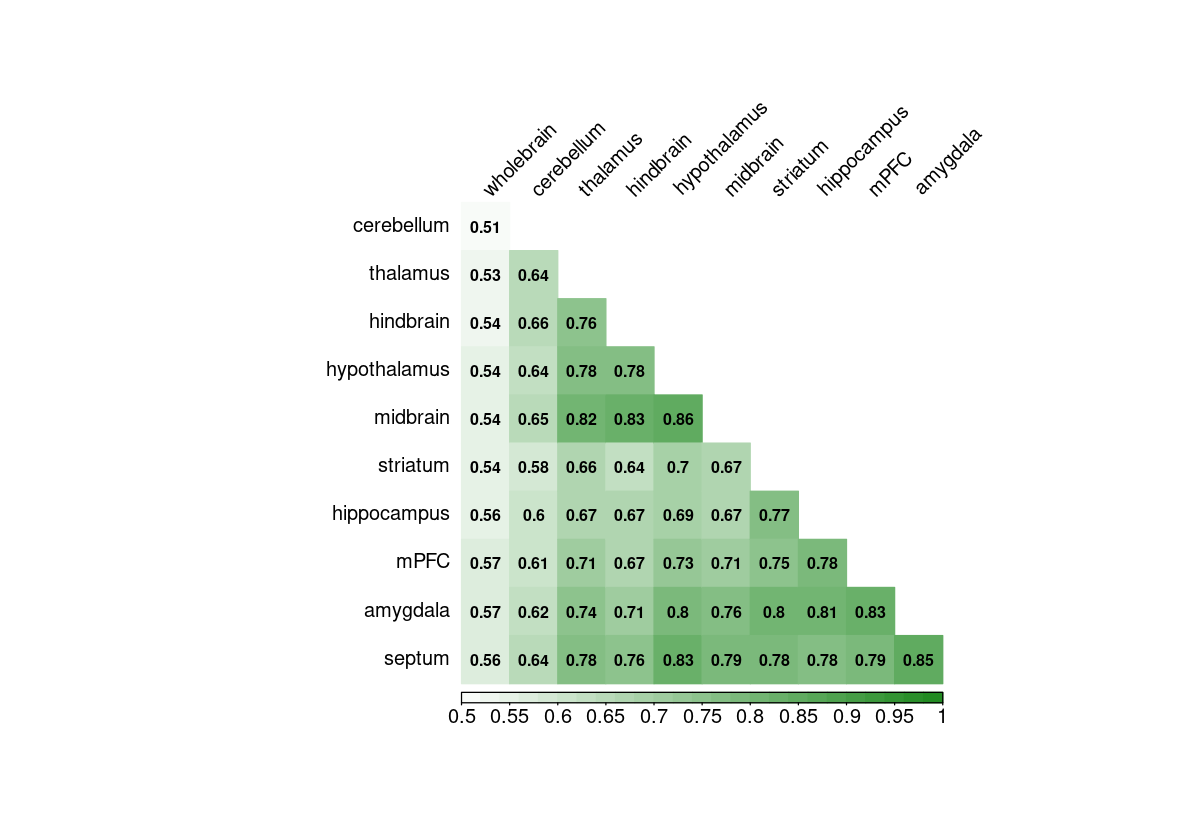

In [76]:
options(repr.plot.width=10,repr.plot.height=7)

corrplot(sharing.species.lfsr0.05.fact0.5.ident, method="color", title="",
        order="hclust", hclust.method="mcquitty", mar=c(4, 0, 4, 0), type="lower",
        bg=NULL, is.corr=T, diag=F, outline=F, addgrid.col=NA, addCoef.col="black", 
        addCoefasPercent=F, addrect=F, tl.pos="lt", tl.cex=1, tl.col="black", tl.offset=0.5, tl.srt=45, 
        cl.pos=NULL, cl.lim=c(0.5,1), cl.length=NULL, cl.cex=1,  
        cl.ratio=0.1, cl.align.text="c", cl.offset=15, number.cex=0.8, 
        col=colorRampPalette(c("white","white","white","white","forestgreen"))(100))

file_name=paste0(plot_path,"/out_RSEM.BW_PO.mashr.species.withWB.sharing.lfsr0.05.fact0.5.ident.corrplot.pdf")
if(!file.exists(file_name)) {
    pdf(file=file_name, width=10, height=7)
    corrplot(sharing.species.lfsr0.05.fact0.5.ident, method="color", title="",
        order="hclust", hclust.method="mcquitty", mar=c(4, 0, 4, 0), type="lower",
        bg=NULL, is.corr=T, diag=F, outline=F, addgrid.col=NA, addCoef.col="white", 
        addCoefasPercent=F, addrect=F, tl.pos="lt", tl.cex=1, tl.col="black", tl.offset=0.5, tl.srt=45, 
        cl.pos=NULL, cl.lim=c(0.5,1), cl.length=NULL, cl.cex=1,  
        cl.ratio=0.1, cl.align.text="c", cl.offset=15, number.cex=1, 
        col=colorRampPalette(c("blue","white","forestgreen"))(100))
    dev.off()
}

## Compare whole brain to subregion calls

Parts of original code written by Caitlin Lewarch - modified to fit general syntax and style here

### Compare whole brain and subregion calls

In [77]:
# add BaseMean column to mashr result data frame and change LFC=0 etc. back to NAs

subregions.dat <- m.can.ed.species.tall %>% full_join(all.species, by=c("gene","subregion")) %>% 
    select(-stat,-pvalue,-padj,-lfcSE,-log2FoldChange) %>% 
    mutate(LFC=replace(LFC,is.na(baseMean),NA),SD=replace(SD,is.na(baseMean),NA),lfsr=replace(lfsr,is.na(baseMean),NA))

# prep whole brain data (use padj as equivalent of lfsr)

WB <- res.species_wholebrain %>% as.data.frame() %>% rownames_to_column("gene") %>%
    select(gene,"WB.LFC"=log2FoldChange,"WB.lfsr"=padj,"WB.baseMean"=baseMean)

# add whole brain calls to subregion calls and determine matches/mismatches and remove genes that are NA in both

compare.wb.sr <- subregions.dat %>% full_join(WB, by="gene") %>% 
    mutate(wb.DE.call=if_else(WB.lfsr < 0.05 & WB.LFC < 0, "up.BW", 
                                if_else(WB.lfsr < 0.05 & WB.LFC > 0, "up.PO", "ns"))) %>%
    mutate(sr.DE.call=if_else(lfsr < 0.05 & LFC < 0, "up.BW", 
                                if_else(lfsr < 0.05 & LFC > 0, "up.PO", "ns"))) %>%
    mutate(sr.wb.match=if_else(wb.DE.call==sr.DE.call, "match", "no_match")) %>%
    filter(!(is.na(baseMean) & is.na(WB.baseMean)))

In [78]:
# combine all subregion data

data.list = list()

for (subregion in subregions_WB){
    data.list[[subregion]] <- get(paste0("prep.species_",subregion))} # add it to your list

all_subregions.simple <- do.call(rbind, data.list) %>% 
    select(gene,subregion,"LFC"=log2FoldChange,padj,baseMean)

In [79]:
# prep whole brain results

WB <- all_subregions.simple %>% filter(subregion=="wholebrain") %>%
    select(gene,"WB.LFC"=LFC,"WB.padj"=padj,"WB.baseMean"=baseMean)

In [80]:
# combine subregion (SR) and whole brain (WB) results

compare.wb.sr <- all_subregions.simple %>% filter(subregion!="wholebrain") %>% 
    full_join(WB, by="gene") %>% 
    mutate(wb.DE.call=if_else(WB.padj < 0.05 & WB.LFC < 0, "up.BW", 
                                if_else(WB.padj < 0.05 & WB.LFC > 0, "up.PO", "ns"))) %>%
    mutate(sr.DE.call=if_else(padj < 0.05 & LFC < 0, "up.BW", 
                                if_else(padj < 0.05 & LFC > 0, "up.PO", "ns"))) %>%
    mutate(sr.wb.match=if_else(wb.DE.call==sr.DE.call, "matched DE call", "mismatched DE call")) %>%
    anti_join(pseudogenes, by="gene")

In [81]:
# add number of genes that match for each subregion (note that pipe is within left_join argument)

compare.wb.sr <- compare.wb.sr %>% left_join(compare.wb.sr %>% group_by(subregion, sr.wb.match) %>% 
    tally() %>% filter(sr.wb.match=="match") %>% select(subregion,n), by="subregion")

In [82]:
# pull out only mismatched genes and break down number by type of mismatch

mismatch <- compare.wb.sr %>% select(-n) %>% filter(!is.na(subregion)) %>% filter(sr.wb.match=="mismatched DE call") %>%
    group_by(subregion, wb.DE.call, sr.DE.call) %>% tally() %>% group_by(subregion) %>%
    mutate(total.mismatches=sum(n), prop.mismatch.type=n/total.mismatches)
mismatch %>% head()

subregion,wb.DE.call,sr.DE.call,n,total.mismatches,prop.mismatch.type
amygdala,ns,up.BW,732,4752,0.15404040
amygdala,ns,up.PO,766,4752,0.16119529
amygdala,up.BW,ns,1610,4752,0.33880471
amygdala,up.BW,up.PO,67,4752,0.01409933
amygdala,up.PO,ns,1529,4752,0.32175926
amygdala,up.PO,up.BW,48,4752,0.01010101


In [83]:
# further characterize mismatch types

mismatch.cause <- compare.wb.sr %>% 
    mutate("subregion.wb.match.2"=
        case_when(wb.DE.call==sr.DE.call ~ "match",
                    wb.DE.call=="ns" & sr.DE.call!="ns" ~ "signal.washed.out.inWB",
                    wb.DE.call!="ns" & sr.DE.call=="ns" ~ "subregion.ns.WB.DE",
                    is.na(wb.DE.call) | is.na(sr.DE.call) ~ "discarded.low.expression.inWBorSR",
                    wb.DE.call=="up.BW" & sr.DE.call=="up.PO" | wb.DE.call=="up.PO" & sr.DE.call=="up.BW" ~ "sign.flip")) %>% 
    select(-n)

In [84]:
mismatch.summary <- mismatch.cause %>% group_by(subregion, subregion.wb.match.2) %>% tally() %>% 
    group_by(subregion) %>% mutate(total.genes=sum(n), prop.mismatch.type=n/total.genes) %>%
    filter_all(all_vars(!is.na(.))) %>%
    mutate(num.match=max(prop.mismatch.type)) %>%
    mutate(subregion.wb.match.2=fct_relevel(subregion.wb.match.2,"discarded.low.expression.inWBorSR","sign.flip","subregion.ns.WB.DE","signal.washed.out.inWB","match"))
mismatch.summary %>% arrange(subregion.wb.match.2,prop.mismatch.type) %>% 
    mutate(perc.mismatch.type=round(prop.mismatch.type*100,2)) %>% group_by(subregion.wb.match.2) %>%
    summarize("min"=min(perc.mismatch.type), "max"=max(perc.mismatch.type))

subregion.wb.match.2,min,max
discarded.low.expression.inWBorSR,2.95,4.80
sign.flip,0.81,2.15
subregion.ns.WB.DE,16.19,22.66
signal.washed.out.inWB,10.01,19.46
match,58.37,63.28


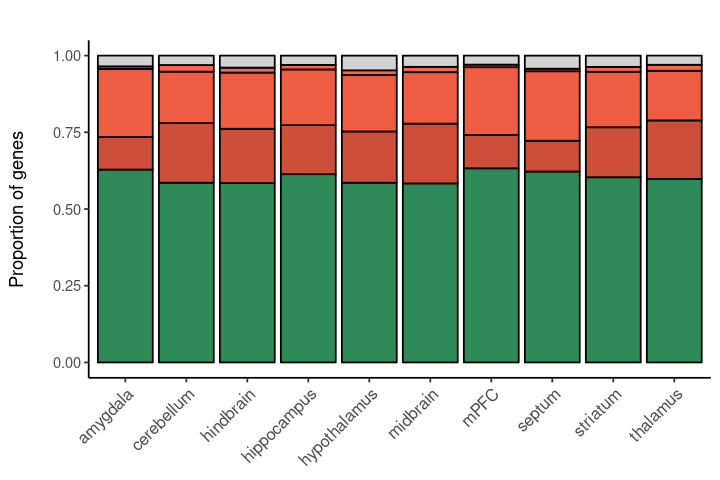

In [85]:
options(repr.plot.height=4,repr.plot.width=6)

ggplot(mismatch.summary, aes(x=subregion, y=prop.mismatch.type, fill=subregion.wb.match.2)) + #fct_reorder(subregion, desc(num.match)
    geom_bar(stat="identity", color="black", position="stack") + theme_classic() + 
    labs(y="Proportion of genes\n", x="", title="") + 
    theme(panel.grid.minor.y=element_line(colour="grey70"), panel.grid.major.y=element_line(colour="grey70"), 
          axis.text.x=element_text(angle=45, hjust=1)) + 
    scale_fill_manual(values=c(match="seagreen4",sign.flip="tomato1",discarded.low.expression.inWBorSR="lightgray",
        subregion.ns.WB.DE="tomato2",signal.washed.out.inWB="tomato3"),        
    labels=c(discarded.low.expression.inWBorSR="discarded (low expression)",sign.flip="sign flip",
             subregion.ns.WB.DE="whole brain DE, subregion NS",signal.washed.out.inWB="subregion DE, whole brain NS",
             match="match"), name="Subregion to whole brain concordance") +
    theme(plot.title=element_text(color="black", size=14, face="bold", hjust=0.5)) +
    theme(axis.text.x=element_text(angle=45, hjust=1, size=10)) + theme(axis.title.x=element_blank()) +
    theme(legend.position="none")

file_name=paste0(plot_path,"out_RSEM.BW_PO.all_subregions_withWB.species.DEcalls_SR_vs_WB_mismatch.rel.pdf")
if(!file.exists(file_name)) {
    ggsave(file_name, width=6, height=4)
}

### Compare whole brain to specific subregion

In [86]:
# Example subregion to whole brain comparison

region="mPFC"

sr.wb.compare <- filter(compare.wb.sr, subregion==region) %>%
    mutate(subregion.wb=paste("subregion", sr.DE.call, "and.whole.brain", wb.DE.call, sep="."))

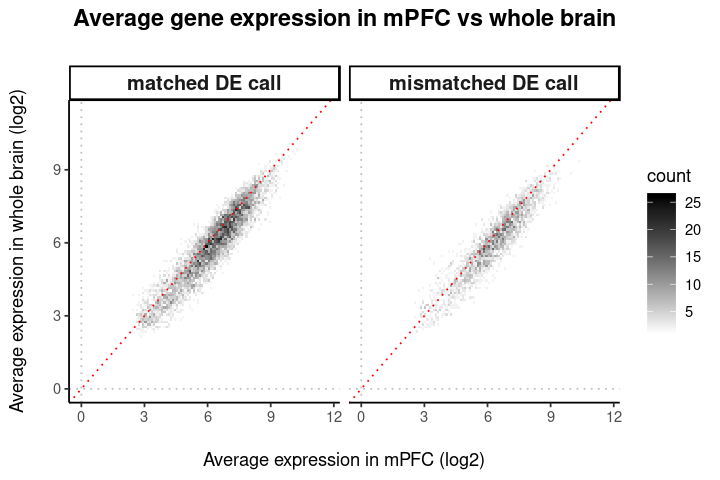

In [87]:
ggplot(filter(sr.wb.compare, !is.na(wb.DE.call) & !is.na(sr.wb.match)), 
        aes(x=log(baseMean), y=log(WB.baseMean))) + 
    geom_bin2d(binwidth=0.1, alpha=1) + theme_classic() + 
    labs(y="Average expression in whole brain (log2)\n", x=paste0("\nAverage expression in ",region," (log2)"), 
             title=paste0("Average gene expression in ",region," vs whole brain\n")) + 
    geom_hline(yintercept=0, lty=3, color="grey") + geom_vline(xintercept=0, lty=3, color="gray") + 
    theme(plot.title=element_text(color="black", size=14, face="bold", hjust=0.5)) +
    facet_wrap(~sr.wb.match) + scale_fill_gradient(low="white", high="black") + 
    geom_abline(slope=1, color="red", lty=3) +
    theme(strip.text=element_text(size=12,face="bold"))

file_name=paste0(plot_path,"out_RSEM.BW_PO.",region,".species.DEcalls_SR_vs_WB.baseMean.pdf")
if(!file.exists(file_name)) {
    ggsave(file_name, width=8, height=4)
}

In [88]:
# whole brain and subregion expression estimates are highly correlated whenever the calls match:

cor.test(filter(sr.wb.compare, !is.na(wb.DE.call)&sr.wb.match=="matched DE call")$baseMean, 
         filter(sr.wb.compare, !is.na(wb.DE.call)&sr.wb.match=="matched DE call")$WB.baseMean, method="pearson")

cat("\nR2 = ", summary(lm(baseMean~WB.baseMean, 
           data=filter(sr.wb.compare, !is.na(wb.DE.call)&sr.wb.match=="matched DE call")))$r.squared)


	Pearson's product-moment correlation

data:  filter(sr.wb.compare, !is.na(wb.DE.call) & sr.wb.match == "matched DE call")$baseMean and filter(sr.wb.compare, !is.na(wb.DE.call) & sr.wb.match == "matched DE call")$WB.baseMean
t = 152.28, df = 8780, p-value < 2.2e-16
alternative hypothesis: true correlation is not equal to 0
95 percent confidence interval:
 0.8458248 0.8573173
sample estimates:
      cor 
0.8516734 



R2 =  0.7253477

In [89]:
# whole brain and subregion expression estimates are also highly correlated whenever the calls do not match:

cor.test(filter(sr.wb.compare, !is.na(wb.DE.call)&sr.wb.match=="mismatched DE call")$baseMean, 
         filter(sr.wb.compare, !is.na(wb.DE.call)&sr.wb.match=="mismatched DE call")$WB.baseMean, method="pearson")

cat("\nR2 = ", summary(lm(baseMean~WB.baseMean, 
           data=filter(sr.wb.compare, !is.na(wb.DE.call)&sr.wb.match=="mismatched DE call")))$r.squared)


	Pearson's product-moment correlation

data:  filter(sr.wb.compare, !is.na(wb.DE.call) & sr.wb.match == "mismatched DE call")$baseMean and filter(sr.wb.compare, !is.na(wb.DE.call) & sr.wb.match == "mismatched DE call")$WB.baseMean
t = 101.42, df = 4685, p-value < 2.2e-16
alternative hypothesis: true correlation is not equal to 0
95 percent confidence interval:
 0.8197244 0.8376525
sample estimates:
      cor 
0.8289012 



R2 =  0.6870771

Warning message:
“Removed 977 rows containing non-finite values (stat_bin2d).”

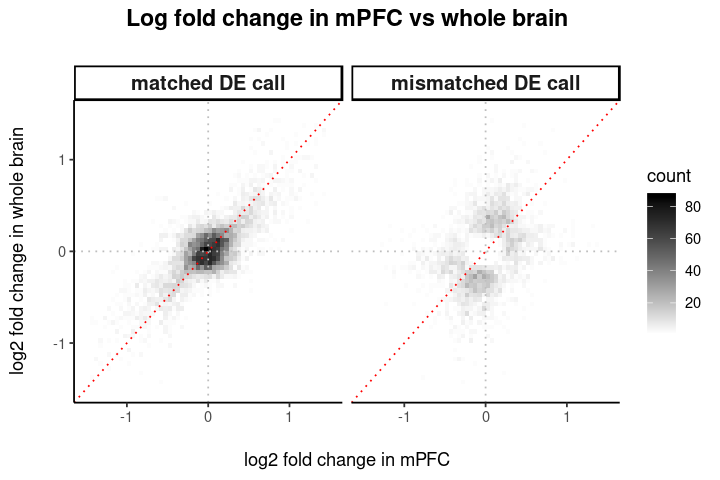

In [90]:
ggplot(filter(sr.wb.compare, !is.na(wb.DE.call) & !is.na(sr.wb.match)), 
       aes(x=LFC, y=WB.LFC)) + 
    geom_bin2d(binwidth=0.05, alpha=1) + theme_classic() + 
    labs(y="log2 fold change in whole brain\n", x=paste0("\nlog2 fold change in ",region), 
         title=paste0("Log fold change in ",region," vs whole brain\n")) +  
    geom_hline(yintercept=0, lty=3, color="grey") + geom_vline(xintercept=0, lty=3, color="gray") + 
    theme(plot.title=element_text(color="black", size=14, face="bold", hjust=0.5)) +
    facet_wrap(~sr.wb.match)+scale_fill_gradient(low="white", high="black") + 
    geom_abline(slope=1, color="red", lty=3) + ylim(-1.5,1.5) + xlim(-1.5,1.5) +
    theme(strip.text=element_text(size=12,face="bold"))

file_name=paste0(plot_path,"out_RSEM.BW_PO.",region,".species.DEcalls_SR_vs_WB.LFC.pdf")
if(!file.exists(file_name)) {
    ggsave(file_name, width=8, height=4)
}

In [91]:
# For genes with matching DE calls, fold change estimates are highly correlated between cerebellum and whole brain samples:

cor.test(filter(sr.wb.compare, !is.na(wb.DE.call)&sr.wb.match=="matched DE call")$LFC, 
         filter(sr.wb.compare, !is.na(wb.DE.call)&sr.wb.match=="matched DE call")$WB.LFC, method="pearson")

cat("R2 = ", summary(lm(LFC~WB.LFC, 
           data=filter(sr.wb.compare, !is.na(wb.DE.call)&sr.wb.match=="matched DE call")))$r.squared)


	Pearson's product-moment correlation

data:  filter(sr.wb.compare, !is.na(wb.DE.call) & sr.wb.match == "matched DE call")$LFC and filter(sr.wb.compare, !is.na(wb.DE.call) & sr.wb.match == "matched DE call")$WB.LFC
t = 212.24, df = 8780, p-value < 2.2e-16
alternative hypothesis: true correlation is not equal to 0
95 percent confidence interval:
 0.9113370 0.9181626
sample estimates:
      cor 
0.9148151 


R2 =  0.8368867

In [92]:
# not so for genes where calls do not match:

cor.test(filter(sr.wb.compare, !is.na(wb.DE.call)&sr.wb.match=="mismatched DE call")$LFC, 
         filter(sr.wb.compare, !is.na(wb.DE.call)&sr.wb.match=="mismatched DE call")$WB.LFC, method="pearson")

cat("\nR2 = ", summary(lm(LFC~WB.LFC, 
           data=filter(sr.wb.compare, !is.na(wb.DE.call)&sr.wb.match=="mismatched DE call")))$r.squared)


	Pearson's product-moment correlation

data:  filter(sr.wb.compare, !is.na(wb.DE.call) & sr.wb.match == "mismatched DE call")$LFC and filter(sr.wb.compare, !is.na(wb.DE.call) & sr.wb.match == "mismatched DE call")$WB.LFC
t = 17.84, df = 4685, p-value < 2.2e-16
alternative hypothesis: true correlation is not equal to 0
95 percent confidence interval:
 0.2252085 0.2788289
sample estimates:
      cor 
0.2522123 



R2 =  0.06361106

### How often is signal just too diluted in whole brain?

In [93]:
# Genes are excluded in any given region (including the whole brain) for low expression, but most genes 
# are assessed in all 10 subregions and the whole brain under the criteria used here:

subregion.tally <- compare.wb.sr %>% select(gene, subregion, sr.DE.call, wb.DE.call) %>%
    mutate(sr.DE.call=as.factor(sr.DE.call), up.BW=if_else(sr.DE.call=="up.BW", 1, 0),
           up.PO=if_else(sr.DE.call=="up.PO", 1, 0), ns=if_else(sr.DE.call=="ns", 1, 0)) %>%
    group_by(gene) %>%
    mutate(num.up.BW=sum(up.BW, na.rm=T), num.up.PO=sum(up.PO, na.rm=T), num.ns=sum(ns, na.rm=T)) %>%
    select(gene, num.up.BW, num.up.PO, num.ns, wb.DE.call) %>% unique() %>%
    mutate(regions.assessed = num.up.BW + num.up.PO + num.ns) %>%
    mutate(assessed.in.all.subregions.and.wb = if_else(regions.assessed==10 & !is.na(wb.DE.call), "yes", "no"))

subregion.tally %>% filter(regions.assessed==0) %>% nrow()

[1] 512

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.


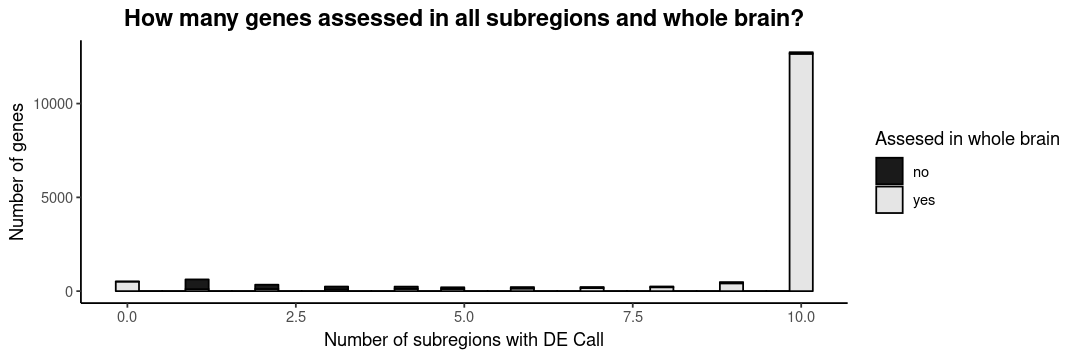

In [94]:
options(repr.plot.width=9, repr.plot.height=3)

ggplot(subregion.tally, aes(x=regions.assessed, fill=as.factor(ifelse(is.na(wb.DE.call), "no", "yes")))) + 
    geom_histogram(color="black") + theme_classic() + 
    scale_fill_manual(name="Assesed in whole brain", values=c("grey10", "grey90")) + 
    labs(y="Number of genes", x="Number of subregions with DE Call", 
         title="How many genes assessed in all subregions and whole brain?") + 
    theme(plot.title = element_text(color="black", size=14, face="bold",hjust=0.5)) #+
    #scale_x_continuous(breaks=c(0,5,10))

In [95]:
subregion.tally.details <- subregion.tally %>%
    mutate(pattern.across.regions=if_else(num.up.PO > 0 & num.up.BW > 0, "sign.flip", 
                                    if_else(num.up.PO==0 & num.up.BW > 0, "at.least.1.BW.biased", 
                                        if_else(num.up.PO > 0 & num.up.BW==0, "at.least.1.PO.biased", 
                                            if_else(num.up.PO==0 & num.up.BW==0, "ns.across.all.regions", "other")))))
subregion.tally.details %>% head()

gene,num.up.BW,num.up.PO,num.ns,wb.DE.call,regions.assessed,assessed.in.all.subregions.and.wb,pattern.across.regions
Zfp160,0,4,6,up.PO,10,yes,at.least.1.PO.biased
Zfp53,1,0,9,ns,10,yes,at.least.1.BW.biased
Ppp2r1a,6,0,4,up.BW,10,yes,at.least.1.BW.biased
Spaca6,0,3,7,ns,10,yes,at.least.1.PO.biased
Zik1,0,9,1,up.PO,10,yes,at.least.1.PO.biased
Myadm,6,0,4,ns,10,yes,at.least.1.BW.biased


In [96]:
subregion.tally.details %>% filter_all(any_vars(is.na(.))) %>% head()

gene,num.up.BW,num.up.PO,num.ns,wb.DE.call,regions.assessed,assessed.in.all.subregions.and.wb,pattern.across.regions
Cdc42ep5,4,0,6,NA,10,no,at.least.1.BW.biased
Gm44587,10,0,0,NA,10,no,at.least.1.BW.biased
Gm36210,3,0,0,NA,3,no,at.least.1.BW.biased
Il11,0,0,2,NA,2,no,ns.across.all.regions
Cox6b2,0,0,7,NA,7,no,ns.across.all.regions
Ptprh,0,0,7,NA,7,no,ns.across.all.regions


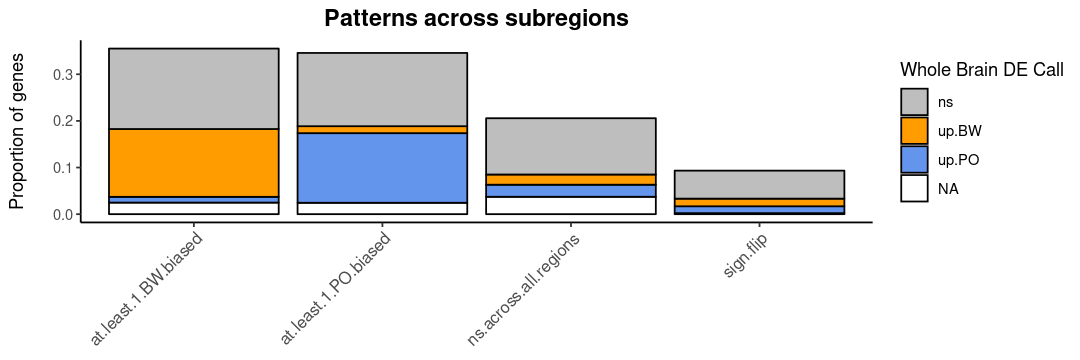

In [97]:
options(repr.plot.width=9, repr.plot.height=3)

ggplot(subregion.tally.details, aes(x=pattern.across.regions, fill=wb.DE.call)) + 
    geom_bar(aes(y=..count../sum(..count..)), color="black") + theme_classic() + 
    labs(y="Proportion of genes\n", x="\nPattern of DE across subregions", title="Patterns across subregions") + 
    scale_fill_manual(values=c(ns="grey", up.BW="#FF9C00", up.PO="#6495ED"), name="Whole Brain DE Call") + 
    theme(panel.grid.minor.y=element_line(colour="grey70"), panel.grid.major.y=element_line(colour="gray70"), 
          axis.text.x=element_text(angle = 45, hjust = 1, size=10), axis.title.x=element_blank()) +
    theme(plot.title=element_text(color="black", size=14, face="bold", hjust=0.5))

file_name=paste0(plot_path,"out_RSEM.BW_PO.all_subregions_withWB.species.DEcalls_SR_vs_WB.patterns.pdf")
if(!file.exists(file_name)) {
    ggsave(file_name, width=9, height=4)
}

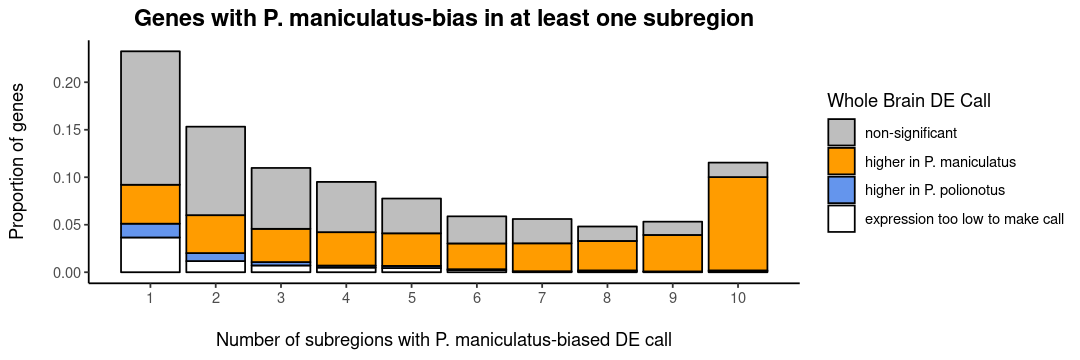

In [98]:
ggplot(filter(subregion.tally.details, pattern.across.regions=="at.least.1.BW.biased"), aes(x=num.up.BW, fill=wb.DE.call)) + 
    geom_bar(aes(y=..count../sum(..count..)), color="black") + theme_classic() + 
    labs(y="Proportion of genes\n", x="\nNumber of subregions with P. maniculatus-biased DE call", 
             title="Genes with P. maniculatus-bias in at least one subregion") + 
    scale_fill_manual(values=c(ns="grey", up.BW="#FF9C00", up.PO="#6495ED"), name="Whole Brain DE Call",
        labels = c("non-significant", "higher in P. maniculatus", "higher in P. polionotus", "expression too low to make call")) + 
    scale_x_continuous(breaks=seq(1,10,1)) +
    theme(plot.title=element_text(color="black", size=14, face="bold", hjust=0.5))

file_name=paste0(plot_path,"out_RSEM.BW_PO.all_subregions_withWB.species.DEcalls_SR_vs_WB.min1BWbiased.pdf")
if(!file.exists(file_name)) {
    ggsave(file_name, width=9, height=4)
}

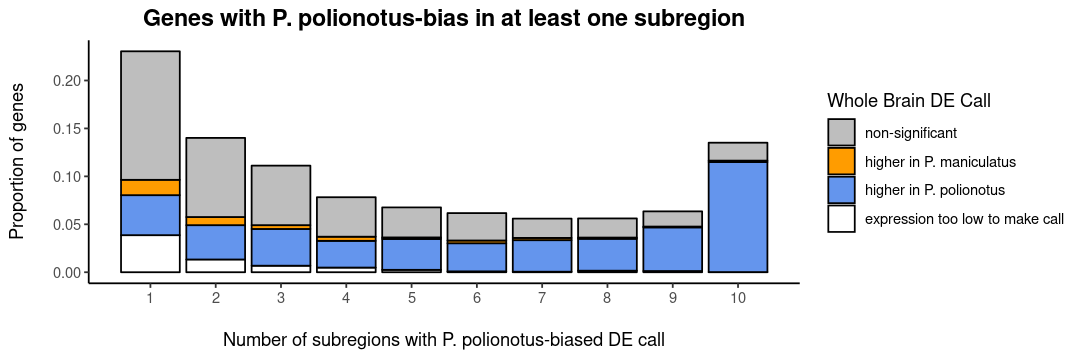

In [99]:
ggplot(filter(subregion.tally.details, pattern.across.regions=="at.least.1.PO.biased"), aes(x=num.up.PO, fill=wb.DE.call)) + 
    geom_bar(aes(y=..count../sum(..count..)), color="black") + theme_classic() + 
    labs(y="Proportion of genes\n", x="\nNumber of subregions with P. polionotus-biased DE call", 
             title="Genes with P. polionotus-bias in at least one subregion") + 
    scale_fill_manual(values=c(ns="grey", up.BW="#FF9C00", up.PO="#6495ED"), name="Whole Brain DE Call",
        labels = c("non-significant", "higher in P. maniculatus", "higher in P. polionotus", "expression too low to make call")) + 
    scale_x_continuous(breaks=seq(1,10,1)) +
    theme(plot.title=element_text(color="black", size=14, face="bold", hjust=0.5))

file_name=paste0(plot_path,"out_RSEM.BW_PO.all_subregions_withWB.species.DEcalls_SR_vs_WB.min1PObiased.pdf")
if(!file.exists(file_name)) {
    ggsave(file_name, width=9, height=4)
}

In [100]:
# DE in all subregions or exactly one subregion

subregion.tally.one_vs_all <- subregion.tally %>% 
    #filter(regions.assessed==10) %>%
    filter(assessed.in.all.subregions.and.wb=="yes") %>%
    mutate(pattern.across.regions=case_when(num.up.PO==0 & num.up.BW==1 ~ "one.BW.biased", 
                                    num.up.PO==1 & num.up.BW==0 ~ "one.PO.biased", 
                                    num.up.PO==0 & num.up.BW==10 ~ "all.BW.biased", 
                                    num.up.PO==10 & num.up.BW==0 ~ "all.PO.biased")) %>% na.omit() %>%
    group_by(pattern.across.regions,wb.DE.call) %>% 
    tally() %>% mutate("proportion"=n/sum(n))
                       
subregion.tally.one_vs_all

pattern.across.regions,wb.DE.call,n,proportion
all.BW.biased,ns,87,0.133231240
all.BW.biased,up.BW,561,0.859111792
all.BW.biased,up.PO,5,0.007656968
all.PO.biased,ns,104,0.138666667
all.PO.biased,up.BW,8,0.010666667
all.PO.biased,up.PO,638,0.850666667
one.BW.biased,ns,683,0.741585233
one.BW.biased,up.BW,164,0.178067318
one.BW.biased,up.PO,74,0.080347448
one.PO.biased,ns,637,0.706992231
